In [1]:
import os
import time

import numpy as np
import pandas 
import geopandas


from shapely.geometry import Point, Polygon
from shapely.ops import unary_union

from matplotlib import pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.patches import FancyBboxPatch, BoxStyle
from matplotlib.path import Path
import re
from pprint import pprint

thisyear = 2018

script_dir = '/home/idies/workspace/Storage/raddick/jordanraddick.com/gerrymandering/'
data_dir = '/home/idies/workspace/Storage/raddick/jordanraddick.com/gerrymandering/districts_with_data/'
output_dir = data_dir

acs5_dir = '/home/idies/workspace/Temporary/raddick/census_scratch/acs5/{0:.0f}/estimates/'.format(thisyear)
shapefiledir = '/home/idies/workspace/Temporary/raddick/census_scratch/shapefiles/{0:.0f}/'.format(thisyear)
extras_dir = '/home/idies/workspace/Storage/raddick/census/extras/'
#separated_roads_dir = output_dir = '/home/idies/workspace/Temporary/raddick/jordanraddick.com_temp/roads/{0:}/'.format(this_state.lower())


#water_area_tol = 1 * 1000 * 1000
#overlap_area_tract_tol = 22000
overlap_area_bg_tol = 4000
#smallest tract in US is Cook County, Illinois Tract 307.02 (area = 22,094 m^2)
#smallest block group in US is Miami-Dade County, FL, Census Tract 2703, block group 7 (area = 4,436 m^2)
equal_area_crs = {'init': 'epsg:2163'}  # An equal area projection: https://epsg.io/2163

#scale = 1
#map_buffer = 0.25 # extra room on each edge of the maps, in degres

#plt.rc('axes', prop_cycle=default_cycler)

district_color_cycle = ['red', 'green', 'orange', 'cyan', 'yellow', 'pink', 'gray', 'lime', 'navajowhite', 'cornflowerblue', 'darkseagreen', 'thistle', 'tomato', 'silver', 'blueviolet', 'olive', 'peru', 'dodgerblue']
inverse_color_cycle = ['green', 'red', 'navy', 'black', 'purple', 'lime', 'black', 'maroon', 'seagreen', 'black', 'red', 'black', 'black', 'white', 'yellow', 'yellow', 'yellow', 'yellow']

debug = 1
g = 0




def makebox(manual_xlim, manual_ylim):

    points = []
    points.append(Point(manual_xlim[0],manual_ylim[1]))
    points.append(Point(manual_xlim[1],manual_ylim[1]))
    points.append(Point(manual_xlim[1],manual_ylim[0]))
    points.append(Point(manual_xlim[0],manual_ylim[0]))
    
    coords = [(p.x, p.y) for p in points]    
    metrobox = Polygon(coords)
    
    return metrobox 

def parse_road_name(thename):
    try:
        annotator = thisrow['FULLNAME'][re.search('\d',thisrow['FULLNAME']).start():]
    except AttributeError:
        try: 
            annotator = thisrow['FULLNAME'][re.search('Hwy',thisrow['FULLNAME']).end():]
        except AttributeError:
            annotator = thisrow['FULLNAME']
    return annotator

# we may derive from matplotlib.patches.BoxStyle._Base class.
# You need to override transmute method in this case.
class shield(BoxStyle._Base):
    """
    A simple box.
    """

    def __init__(self, pad=0.3):
        """
        The arguments need to be floating numbers and need to have
        default values.

         *pad*
            amount of padding
        """

        self.pad = pad
        super().__init__()

    def transmute(self, x0, y0, width, height, mutation_size):
        """
        Given the location and size of the box, return the path of
        the box around it.

         - *x0*, *y0*, *width*, *height* : location and size of the box
         - *mutation_size* : a reference scale for the mutation.

        Often, the *mutation_size* is the font size of the text.
        You don't need to worry about the rotation as it is
        automatically taken care of.
        """

        # padding
        pad = mutation_size * self.pad

        # width and height with padding added.
        width, height = width + 2.*pad, \
                        height + 2.*pad,

        # boundary of the padded box
        x0, y0 = x0-pad, y0-pad,
        x1, y1 = x0+width, y0 + height

        cp = [(0.5*(x0+x1), (y0-2.*pad)), # bottom
              (x1, y0),  # right lower-mid
              (x1+pad, (y0+y1)/2.),  # far right mid
              (x1, y1+pad),  # top right corner
              ((x0+x1)/2,y1),  # dip from top
              (x0, y1+pad),  # top left corner
              (x0-pad, (y0+y1)/2.),    # far left mid
              (x0, y0),  # left lower-mid
              ((x0+x1)/2., (y0-2.*pad)),  # return to bottom
              ((x0+x1)/2., (y0-2.*pad))]
        
        
        com = [Path.MOVETO,  # start
               Path.CURVE4, # curve to right mid
               Path.LINETO,  # line to far right mid
               Path.LINETO, # line to top right corner
               Path.CURVE3,  # line to dip
               Path.LINETO,  # line to top left corner
               Path.CURVE4,   # curve to far left mid
               Path.LINETO,   # line to left lower-mid
               Path.LINETO,
               Path.CLOSEPOLY]

        path = Path(cp, com)

        return path

BoxStyle._style_list["shield"] = shield

road_label_format = { 
    'I': { 'labelsize': 14, 'thecolor': 'red', 'thebbox': dict(boxstyle="shield", fc='blue', ec='red') },     
    'U': { 'labelsize': 11, 'thecolor': 'black', 'thebbox': dict(boxstyle="shield", fc='white', ec='black') },
    'S': { 'labelsize': 9, 'thecolor': 'black', 'thebbox': dict(boxstyle="square,pad=0.25", fc='white', ec='black')},
    'C': { 'labelsize': 10, 'thecolor': 'black', 'thebbox': dict(boxstyle="sawtooth,pad=0.5", fc='white') }, 
    'M': { 'labelsize': 9, 'thecolor': 'black'},
    'O': { 'labelsize': 9, 'thecolor': 'red' }
}
print('ok')


ok


# Get congressional district shapefiles (nationwide)

In [2]:
s = time.time()
print('reading congressional districts with urban/rural area data...')
cd_gdf = geopandas.read_file(data_dir+'cd116_with_areas_and_types_435.shp')

print('Fixing at-large districts by setting district number to 1...')
cd_gdf.loc[cd_gdf['CD116FP'] == 0, 'CD116FP'] = 1  # At-large districts will be called District 1

cd_gdf = cd_gdf.rename(columns = {'pct_metro_': 'pct_metro_area', 'pct_city_a': 'pct_city_area'})
cd_gdf.loc[:, 'CD116FP'] = cd_gdf['CD116FP'].apply(lambda x: int(x))
cd_gdf = cd_gdf.set_index('GEOID')

e = time.time()
g = g + (e-s)
print('Read {0:,.0f} districts in {1:,.1f} seconds.'.format(len(cd_gdf), e-s))
#sorted(cd_gdf[cd_gdf['CD116FP'] == 0]['STUSAB'].tolist())


reading congressional districts with urban/rural area data...
Fixing at-large districts by setting district number to 1...
Read 435 districts in 2.2 seconds.


# Get block groups (nationwide)

In [3]:
s = time.time()
bg_file_list = [shapefiledir+'BG/'+x for x in os.listdir(shapefiledir+'BG/') if ((x[-4:] == '.shp'))]
bg_gdf = geopandas.GeoDataFrame()

for i in range(0, len(bg_file_list)):
    if (debug >= 1):
        if ((np.mod(i,10) == 0) | (i == len(bg_file_list)-1)):
            print('\tReading file {0:,.0f} of {1:,.0f}...'.format(i+1, len(bg_file_list)))
    bg_gdf_i = geopandas.read_file(bg_file_list[i])
    bg_gdf = pandas.concat((bg_gdf, bg_gdf_i), axis=0, sort=False)

print('converting block group identifiers and coords to numeric...')
bg_gdf.loc[:, 'STATEFP'] = pandas.to_numeric(bg_gdf['STATEFP'], errors='coerce')
bg_gdf.loc[:, 'COUNTYFP'] = pandas.to_numeric(bg_gdf['COUNTYFP'], errors='coerce')
bg_gdf.loc[:, 'TRACTCE'] = pandas.to_numeric(bg_gdf['TRACTCE'].apply(lambda x: x[0:4]+'.'+x[4:]), errors='coerce')
bg_gdf.loc[:, 'BLKGRPCE'] = pandas.to_numeric(bg_gdf['BLKGRPCE'], errors='coerce')
bg_gdf.loc[:, 'INTPTLAT'] = pandas.to_numeric(bg_gdf['INTPTLAT'], errors='coerce')
bg_gdf.loc[:, 'INTPTLON'] = pandas.to_numeric(bg_gdf['INTPTLON'], errors='coerce')

#bg_gdf.loc[:, 'NAME'] = pandas.to_numeric(tract_gdf['NAME'], errors='coerce')
# bg_gdf = tract_gdf.sort_values(by='NAME')

print('assigning GEOID as index...')
bg_gdf.loc[:, 'GEOID'] = bg_gdf['GEOID'].apply(lambda x: '15000US'+str(x))
bg_gdf = bg_gdf.set_index('GEOID')

e = time.time()
g = g + (e-s)
if (debug >= 1):
    print('Read {0:,.0f} census block groups in {1:,.1f} seconds!'.format(len(bg_gdf), e-s))

#bg_gdf.sample(1).T


	Reading file 1 of 51...
	Reading file 11 of 51...
	Reading file 21 of 51...
	Reading file 31 of 51...
	Reading file 41 of 51...
	Reading file 51 of 51...
converting block group identifiers and coords to numeric...
assigning GEOID as index...
Read 217,739 census block groups in 150.0 seconds!


## Look up state and county names from numbers

In [4]:
s = time.time()

print('looking up state names from numbers...')
state_codes_df = pandas.read_csv(extras_dir+'statecodes.csv')
state_codes_df = state_codes_df.rename(columns={'STATE': 'STATEFP'})
bg_gdf = bg_gdf.reset_index().merge(state_codes_df, how='left', on='STATEFP').set_index('GEOID')


print('looking up county names from numbers...')
county_names_df = pandas.read_excel(extras_dir+'all-geocodes-v2019.xlsx', header=4)
county_names_df = county_names_df[county_names_df['Summary Level'] == 50]
county_names_df = county_names_df.rename(columns={'State Code (FIPS)': 'STATEFP', 'County Code (FIPS)': 'COUNTYFP', 'Area Name (including legal/statistical area description)': 'COUNTY_NAME' })
bg_gdf = bg_gdf.reset_index().merge(county_names_df[['STATEFP', 'COUNTYFP', 'COUNTY_NAME']], how='left', on=['STATEFP', 'COUNTYFP']).set_index('GEOID')

e = time.time()
g = g + (e-s)
print('Added state and county names in {0:,.1f} seconds!'.format(e-s))


looking up state names from numbers...
looking up county names from numbers...
Added state and county names in 15.2 seconds!


## Get block group population data, join onto block group shapeifles

In [5]:
s = time.time()
print('reading ACS5 census data for {0:.0f}...'.format(thisyear))
acs5_estimates_df = pandas.read_csv(acs5_dir+'estimates_acs{0:}_tract_bg_gerrymandering.csv'.format(thisyear), index_col='GEOID')

print('joining population data onto block group shapefiles...')
bg_gdf = bg_gdf.join(acs5_estimates_df[['B01001_001', 'Geography Name']], how='left')
bg_gdf = bg_gdf.rename(columns={'B01001_001': 'total_population'})

e = time.time()
g = g + (e-s)
print('\nadded ACS5 census data to {0:,.0f} block groups in {1:,.0f} seconds!'.format(len(bg_gdf), e-s))


reading ACS5 census data for 2018...
joining population data onto block group shapefiles...

added ACS5 census data to 217,739 block groups in 5 seconds!


# Get what has already been matched

## From file (comment out if you haven't run this script before)

In [6]:
# s = time.time()
# print('reading districts that have been matched so far...')
# assembler_df = pandas.read_csv(output_dir+'raw_district_files/ak_to_fl.csv', encoding='utf-8', index_col='GEOID')
# assembler_gdf = geopandas.GeoDataFrame(assembler_df.join(bg_gdf.geometry))
# assembler_gdf.crs = bg_gdf.crs


# # cd_gdf = cd_gdf[~cd_gdf['STUSAB'].isin(assembler_gdf['STUSAB'].drop_duplicates().tolist())]
# # bg_gdf = bg_gdf[~bg_gdf['STUSAB'].isin(assembler_gdf['STUSAB'].drop_duplicates().tolist())]

# print('backing up...')
# # cd_gdf_bk = cd_gdf
# # bg_gdf_bk = bg_gdf
# assembler_gdf_bk = assembler_gdf

# e = time.time()
# g = g + (e-s)
# print('Kept {0:,.0f} block groups in {1:,.1f} seconds!'.format(len(bg_gdf),e-s))

# assembler_gdf.groupby('STUSAB')['block_based_district'].max().sort_values(ascending=False)


## From scratch

In [7]:
s = time.time()
print('reading districts that have been matched so far...')

assembler_df = pandas.read_csv(data_dir+'block_group_with_district_1_18.csv', encoding='utf-8', index_col='GEOID')
assembler_gdf = geopandas.GeoDataFrame(assembler_df.join(bg_gdf.geometry))
assembler_gdf.crs = bg_gdf.crs


# cd_gdf = cd_gdf[~cd_gdf['STUSAB'].isin(assembler_gdf['STUSAB'].drop_duplicates().tolist())]
# bg_gdf = bg_gdf[~bg_gdf['STUSAB'].isin(assembler_gdf['STUSAB'].drop_duplicates().tolist())]

# print('backing up...')
# cd_gdf_bk = cd_gdf
# bg_gdf_bk = bg_gdf
# assembler_gdf_bk = assembler_gdf

e = time.time()
g = g + (e-s)
print('Kept {0:,.0f} block groups in {1:,.1f} seconds!'.format(len(bg_gdf),e-s))




reading districts that have been matched so far...
Kept 217,739 block groups in 2.1 seconds!


## Read this state's matched block groups from file

### Create a function to match districts

In [8]:
def mark_block_groups_with_districts_bitmask_values(block_group_info_gdf, congressional_district_info_gdf, debug=0):    
    working_with_state = block_group_info_gdf['STATE_NAME'].head(1).values[0]
    
    marked_s = pandas.Series()
    
    equal_area_crs = {'init': 'epsg:2163'}  # An equal area projection: https://epsg.io/2163
    cnt = 0
    if (debug > 0):    
        print('\tAssigning bitmask values to block groups in {0:}...'.format(working_with_state))
    
    for ix, thisrow in block_group_info_gdf.iterrows():    
        bitmasker = 0
        if (debug > 1):
            print(ix)
            print('\t\tMatching {0:}, {1:} census tract {2:}, block group {3:}...'.format(thisrow['STATE_NAME'], thisrow['COUNTY_NAME'], thisrow['TRACTCE'], thisrow['BLKGRPCE']))
            print('\n')
        if ((np.mod(cnt,1000) == 0) | (cnt == len(block_group_info_gdf) - 1)):
            if (debug > 1):
                print('\t\t\tprocessing row {0:,.0f} of {1:,.0f}...'.format(cnt+1, len(bg_gdf[bg_gdf['STUSAB'] == this_state])))
            else:
                print('\t\tprocessing row {0:,.0f} of {1:,.0f}...'.format(cnt+1, len(bg_gdf[bg_gdf['STUSAB'] == this_state])))
                
        for jx, thatrow in congressional_district_info_gdf.iterrows():
            if (thisrow.geometry.intersects(thatrow.geometry)):
                this_district_overlap_area = block_group_info_gdf[block_group_info_gdf.index == ix].to_crs(equal_area_crs).geometry.values[0].intersection(congressional_district_info_gdf[congressional_district_info_gdf.index == jx].to_crs(equal_area_crs).geometry.values[0]).area
                if (this_district_overlap_area >= overlap_area_bg_tol):
                    bitmasker = bitmasker + 2**(thatrow['CD116FP']-1)
                    if (debug > 1):
                        print('\t\t\t\tIntersects District {0:.0f} with overlap area {1:,.1f} km^2...'.format(thatrow['CD116FP'], this_district_overlap_area/1000000))               
        marked_s.loc[ix] = bitmasker
        cnt = cnt + 1
        
    return marked_s
print('defined district-marking function!')


defined district-marking function!


### Find block group / district overlaps, assign districts to non-overlapping block groups

Uses function defined above

In [9]:
s = time.time()

for this_state in ['NY', 'FL']:
#    print('File not found, reading from nationwide data...')
    state_full_name = bg_gdf[bg_gdf['STUSAB'] == this_state]['STATE_NAME'].values[0]
    print('\n')
    print('Processing {0:}...'.format(state_full_name))
    assembler_i_gdf = bg_gdf[bg_gdf['STUSAB'] == this_state]

    district_bitmask_values_s = mark_block_groups_with_districts_bitmask_values(
        bg_gdf[bg_gdf['STUSAB'] == this_state][['STATE_NAME', 'COUNTY_NAME', 'TRACTCE', 'BLKGRPCE', 'total_population', 'geometry']], 
        cd_gdf[cd_gdf['STUSAB'] == this_state][['STUSAB', 'CD116FP', 'geometry']], 
        debug
    )
    assembler_i_gdf = assembler_i_gdf.assign(congressional_districts_bitmask_values = district_bitmask_values_s)


    if (debug > 0):
        print('\tconverting bitmask values to human-readable bitmasks...')        
    nDistrictsForBitmaskeration = cd_gdf[cd_gdf['STUSAB'] == this_state]['CD116FP'].max()
    assembler_i_gdf = assembler_i_gdf.assign(congressional_districts_bitmask = 
                                             assembler_i_gdf['congressional_districts_bitmask_values'].apply(lambda x: 'x'+np.binary_repr(int(x)).zfill(nDistrictsForBitmaskeration)[::-1])
                                            )

    if (debug > 0):
        print('\tcounting number of districts each block group overlaps...')        

    assembler_i_gdf = assembler_i_gdf.assign(nDistricts = 
                                             assembler_i_gdf['congressional_districts_bitmask'].apply(lambda x: x[1:].count("1"))
                                            )
    if (debug > 0):
        print('\tassigning congressional district to each block group with only one overlap...')

    assembler_i_gdf = assembler_i_gdf.assign(block_based_district = np.nan)
    assembler_i_gdf.loc[
        assembler_i_gdf['nDistricts'] == 1, 
        'block_based_district'] = assembler_i_gdf[
                        assembler_i_gdf['nDistricts'] == 1
                    ]['congressional_districts_bitmask'].apply(lambda x: x.find("1"))

    print('\t...-1 otherwise...')
    assembler_i_gdf.loc[assembler_i_gdf['nDistricts'] > 1, 'block_based_district'] = -1

    #assembler_i_gdf.to_file(output_dir+'raw_district_files/nj_raw.shp')

    if (debug > 0):
        print('\tjoining {0:} to the rest of the assembler dataframe...'.format(state_full_name))
    assembler_gdf = pandas.concat((assembler_gdf, assembler_i_gdf), axis=0, sort=True)
    if (debug > 0):
        print("\n")
e = time.time()
g = g + (e-s)

print('matched districts for {0:,.0f} block groups in {1:} in {2:,.0f} minutes {3:,.0f} seconds!'.format(len(assembler_i_gdf), this_state, np.floor((e-s)/60), np.floor((e-s)%60)))

# print('backing up...')
# assembler_gdf_justparsed = assembler_gdf

e = time.time()
g = g + (e-s)

#print('Read {0:,.0f} rows in {1:,.0f} seconds!'.format(e-s, ))
print('Got {0:,.0f} block groups in {1:,.0f} minutes {2:,.0f} seconds!'.format(len(assembler_gdf), np.floor((e-s)/60), np.floor((e-s)%60)))

# print(assembler_gdf.groupby('STUSAB').size())
# print(assembler_gdf.groupby(['STUSAB', 'nDistricts']).size())
#print(assembler_gdf.groupby(['STUSAB', 'block_based_district']).size())
# assembler_gdf.sample(2).T
#assembler_gdf[assembler_gdf['STUSAB'] == this_state].groupby('congressional_districts_bitmask').size()
assembler_gdf.groupby('STUSAB')['block_based_district'].max().sort_values(ascending=False)




Processing New York...
	Assigning bitmask values to block groups in New York...
		processing row 1 of 15,463...
		processing row 1,001 of 15,463...
		processing row 2,001 of 15,463...
		processing row 3,001 of 15,463...
		processing row 4,001 of 15,463...
		processing row 5,001 of 15,463...
		processing row 6,001 of 15,463...
		processing row 7,001 of 15,463...
		processing row 8,001 of 15,463...
		processing row 9,001 of 15,463...
		processing row 10,001 of 15,463...
		processing row 11,001 of 15,463...
		processing row 12,001 of 15,463...
		processing row 13,001 of 15,463...
		processing row 14,001 of 15,463...
		processing row 15,001 of 15,463...
		processing row 15,463 of 15,463...
	converting bitmask values to human-readable bitmasks...
	counting number of districts each block group overlaps...
	assigning congressional district to each block group with only one overlap...
	...-1 otherwise...
	joining New York to the rest of the assembler dataframe...




Processing Florida...
	A

STUSAB
FL    27.0
NY    27.0
IL    18.0
PA    18.0
OH    16.0
MI    14.0
GA    14.0
NC    13.0
NJ    12.0
VA    11.0
WA    10.0
IN     9.0
AZ     9.0
MA     9.0
TN     9.0
MD     8.0
WI     8.0
MO     8.0
MN     8.0
AL     7.0
SC     7.0
CO     7.0
KY     6.0
LA     6.0
OK     5.0
OR     5.0
CT     5.0
IA     4.0
KS     4.0
MS     4.0
NV     4.0
AR     4.0
UT     4.0
WV     3.0
NM     3.0
NE     3.0
ME     2.0
NH     2.0
RI     2.0
ID     2.0
HI     2.0
WY     1.0
DE     1.0
MT     1.0
ND     1.0
SD     1.0
VT     1.0
AK     1.0
Name: block_based_district, dtype: float64

### Save file

In [10]:
# s = time.time()
# pandas.DataFrame(assembler_gdf[[x for x in assembler_gdf.columns if x != 'geometry']]
#                 ).to_csv(output_dir+'raw_district_files/ak_to_fl.csv', encoding='utf-8')
# e = time.time()
# g = g + (e-s)

# print('Wrote out {0:,.0f} block groups in {1:,.0f} minutes {2:,.0f} seconds!'.format(len(assembler_gdf), np.floor((e-s)/60), np.floor((e-s)%60)))


## Match by hand

In [11]:
##### NEW YORK
##       New York City
assembler_gdf.loc[['15000US361039901000'], 'block_based_district'] = 1
assembler_gdf.loc[['15000US361031352042', '15000US361031349061', '15000US361031349072', '15000US361031349071'], 'block_based_district'] = 1
assembler_gdf.loc[['15000US361031352011', '15000US361031347031', '15000US361031347034', '15000US361031352042', '15000US361031347042'], 'block_based_district'] = 3
assembler_gdf.loc[['15000US360595201005', '15000US360595204012', '15000US360595204013'], 'block_based_district'] = 3
assembler_gdf.loc[['15000US360594169001'], 'block_based_district'] = 4
assembler_gdf.loc[['15000US360593028001', '15000US360593033023', '15000US360593033024', '15000US360593035004'], 'block_based_district'] = 4
assembler_gdf.loc[['15000US360811385021'], 'block_based_district'] = 3
assembler_gdf.loc[['15000US360811059004', '15000US360811093002', '15000US360811113001'], 'block_based_district'] = 6
assembler_gdf.loc[['15000US360810973001'], 'block_based_district'] = 3
assembler_gdf.loc[['15000US360810945001', '15000US360810945002'], 'block_based_district'] = 7
assembler_gdf.loc[['15000US360599904000'], 'block_based_district'] = 4
assembler_gdf.loc[['15000US360594048002', '15000US360594113011', '15000US360594108004', '15000US360594046002', '15000US360594057004', '15000US360594105003', '15000US360594054004', '15000US360594100003'], 'block_based_district'] = 4
assembler_gdf.loc[['15000US360594048003', '15000US360594110001', '15000US360594106004', '15000US360594106005', '15000US360594106006', '15000US360594106007'], 'block_based_district'] = 5
assembler_gdf.loc[['15000US360810492001', '15000US360810552001', '15000US360811267001', '15000US360810212002', '15000US360810236002', '15000US360810446021', '15000US360810132002', '15000US360810026001', '15000US360810128001', '15000US360810026002'], 'block_based_district'] = 5
assembler_gdf.loc[['15000US360811283001', '15000US360810456001', '15000US360810458001', '15000US360810448001', '15000US360810132001' , '15000US360810130001'], 'block_based_district'] = 6
assembler_gdf.loc[['15000US360810086001', '15000US360810892002'], 'block_based_district'] = 8
assembler_gdf.loc[['15000US360810567002', '15000US360810585003', '15000US360810593001', '15000US360810593002', '15000US360810595001'], 'block_based_district'] = 6
assembler_gdf.loc[['15000US360810595002', '15000US360810561001'], 'block_based_district'] = 7
assembler_gdf.loc[['15000US360810229001'], 'block_based_district'] = 6
assembler_gdf.loc[['15000US360810483002', '15000US360810513001', '15000US360810467004', '15000US360810265002', '15000US360810267003', '15000US360810461001', '15000US360810469005'], 'block_based_district'] = 6
assembler_gdf.loc[['15000US360810383021', '15000US360810437012', '15000US360810437021', '15000US360810271003'], 'block_based_district'] = 14
assembler_gdf.loc[['15000US360470399003', '15000US360470411001', '15000US360470413002', '15000US360470191001'], 'block_based_district'] = 7
assembler_gdf.loc[['15000US360810054003', '15000US360810054004', '15000US360471192003', '15000US360471190001', '15000US360471144001', '15000US360470405001', '15000US360470411003', '15000US360470413001', '15000US360470413003', '15000US360470037001', '15000US360470211002'], 'block_based_district'] = 8
assembler_gdf.loc[['15000US360470013001', '15000US360470011001', '15000US360470257001', '15000US360470287001', '15000US360470543002'], 'block_based_district'] = 8
assembler_gdf.loc[['15000US360470131001', '15000US360470131002', '15000US360470149005'], 'block_based_district'] = 7
assembler_gdf.loc[['15000US360470149004'], 'block_based_district'] = 9
assembler_gdf.loc[['15000US360610041005', '15000US360610005002', '15000US360470119001', '15000US360470117003', '15000US360470101003', '15000US360470110002', '15000US360470022003', '15000US360470212001', '15000US360470214002'], 'block_based_district'] = 7
assembler_gdf.loc[['15000US360610015012', '15000US360610015013', '15000US360610041006', '15000US360610043003', '15000US360470112001', '15000US360470224004', '15000US360470112004'], 'block_based_district'] = 10
assembler_gdf.loc[['15000US360470053003', '15000US360470118002'], 'block_based_district'] = 7
assembler_gdf.loc[['15000US360470070001', '15000US360470120001', '15000US360470212003'], 'block_based_district'] = 10
assembler_gdf.loc[['15000US360470053001', '15000US360470018001'], 'block_based_district'] = 10   # Coast of Manhattan fixes
assembler_gdf.loc[['15000US360470449004', '15000US360610028004', '15000US360610018001', '15000US360610018002', '15000US360470553002', '15000US360470519003', '15000US360470513003'], 'block_based_district'] = 7
assembler_gdf.loc[['15000US360470555001', '15000US360610018003', '15000US360610030011', '15000US360610030012', '15000US360610014012', '15000US360610012001', '15000US360610022011', '15000US360470495001', '15000US360470495002', '15000US360470495003', '15000US360470513001'], 'block_based_district'] = 12
assembler_gdf.loc[['15000US360470666001', '15000US360470656001', '15000US360470650001', '15000US360470724002', '15000US360470934001', '15000US360470944012', '15000US360470203001', '15000US360470203002', '15000US360470221001', '15000US360470305001', '15000US360470311001'], 'block_based_district'] = 8
assembler_gdf.loc[['15000US360470363001', '15000US360470906002', '15000US360470920003', '15000US360470920001', '15000US360470920002'], 'block_based_district'] = 8
assembler_gdf.loc[['15000US360470726001', '15000US360470732001', '15000US360470732002', '15000US360470944013', '15000US360470636001', '15000US360470347001', '15000US360470918002', '15000US360470916003', '15000US360470916004'], 'block_based_district'] = 9
assembler_gdf.loc[['15000US360479901000', '15000US360470354001', '15000US360470366001', '15000US360470348001'], 'block_based_district'] = 8
assembler_gdf.loc[['15000US360470592001'], 'block_based_district'] = 9
assembler_gdf.loc[['15000US360470580001', '15000US360470580002'], 'block_based_district'] = 11
assembler_gdf.loc[['15000US360470424003', '15000US360470300002', '15000US360470274001', '15000US360470304002', '15000US360470424002', '15000US360470270002', '15000US360470276002', '15000US360470276003', '15000US360470304003', '15000US360470402001'], 'block_based_district'] = 10
assembler_gdf.loc[['15000US360470128011', '15000US360470210001', '15000US360470210002', '15000US360470210003', '15000US360470186001', '15000US360470188001', '15000US360470188002'], 'block_based_district'] = 10
assembler_gdf.loc[['15000US360470400003', '15000US360470296001', '15000US360470304001', '15000US360470402002', '15000US360470412001', '15000US360470412002', '15000US360470034001', '15000US360470030002', '15000US360470068004'], 'block_based_district'] = 11
assembler_gdf.loc[['15000US360470196001', '15000US360470196003', '15000US360470190003'], 'block_based_district'] = 11
assembler_gdf.loc[['15000US360610113001', '15000US360610055011' , '15000US360610059003'], 'block_based_district'] = 10
assembler_gdf.loc[['15000US360610101001', '15000US360610109001', '15000US360610119002', '15000US360610043001', '15000US360610055022', '15000US360610059002'], 'block_based_district'] = 12
assembler_gdf.loc[['15000US360610197011'], 'block_based_district'] = 10
assembler_gdf.loc[['15000US360610143001'], 'block_based_district'] = 13
assembler_gdf.loc[['15000US360610156021'], 'block_based_district'] = 13
assembler_gdf.loc[['15000US360810099001', '15000US360810147003', '15000US360810155001', '15000US360810171001', '15000US360810179002'], 'block_based_district'] = 12
assembler_gdf.loc[['15000US360810095002', '15000US360810125001', '15000US360810125002', '15000US360810159001', '15000US360810187001', '15000US360810187003', '15000US360810189002', '15000US360810205002', '15000US360810179001'], 'block_based_district'] = 14
assembler_gdf.loc[['15000US360050429011'], 'block_based_district'] = 13
assembler_gdf.loc[['15000US360050255002', '15000US360050205011', '15000US360050205012', '15000US360050247001'], 'block_based_district'] = 13
assembler_gdf.loc[['15000US360050399012', '15000US360050205014', '15000US360050255003'], 'block_based_district'] = 15
assembler_gdf.loc[['15000US360050285004', '15000US360050287001', '15000US360050289003'], 'block_based_district'] = 13
assembler_gdf.loc[['15000US360050334001', '15000US360050096001', '15000US360050096002', '15000US360050092003', '15000US360050092001', '15000US360050092005', '15000US360050216022', '15000US360050222002', '15000US360050240001', '15000US360050240003'], 'block_based_district'] = 14
assembler_gdf.loc[['15000US360050456003'], 'block_based_district'] = 14
assembler_gdf.loc[['15000US360050397001', '15000US360050090000', '15000US360050220001'], 'block_based_district'] = 15
assembler_gdf.loc[['15000US360050338004', '15000US360050342002', '15000US360050360003'], 'block_based_district'] = 14
assembler_gdf.loc[['15000US360050338002', '15000US360050350002', '15000US360050302001', '15000US360050302004'], 'block_based_district'] = 16
assembler_gdf.loc[['15000US361190099001', '15000US361190099002', '15000US361190100001', '15000US361190100003', '15000US361190107013', '15000US361190107023'], 'block_based_district'] = 16
assembler_gdf.loc[['15000US361190108012'], 'block_based_district'] = 17
assembler_gdf.loc[['15000US361190123032', '15000US361190131043', '15000US361190148052'], 'block_based_district'] = 17
assembler_gdf.loc[['15000US361190123042'], 'block_based_district'] = 18

###### Rural
assembler_gdf.loc[['15000US360270502051', '15000US360270704011', '15000US360270704013', '15000US360271402004', '15000US360270801032', '15000US360270801031'], 'block_based_district'] = 18
assembler_gdf.loc[['15000US360270802023', '15000US360271402001'], 'block_based_district'] = 19
assembler_gdf.loc[['15000US360570727003', '15000US360830519021', '15000US360830525013', '15000US360830525014', '15000US360830525021', '15000US360830525022', '15000US360830525023'], 'block_based_district'] = 19
assembler_gdf.loc[['15000US360070124001'], 'block_based_district'] = 19
assembler_gdf.loc[['15000US360910617011', '15000US360910620001'], 'block_based_district'] = 20
assembler_gdf.loc[['15000US360910620004'], 'block_based_district'] = 21
assembler_gdf.loc[['15000US360430115013'], 'block_based_district'] = 21
assembler_gdf.loc[['15000US360430110023'], 'block_based_district'] = 22
assembler_gdf.loc[['15000US361070206005', '15000US361070206006', '15000US361070204014'], 'block_based_district'] = 22
assembler_gdf.loc[['15000US361070203003', '15000US361070203004', '15000US361070203005'], 'block_based_district'] = 23
assembler_gdf.loc[['15000US360750215011'], 'block_based_district'] = 22
assembler_gdf.loc[['15000US360759900000', '15000US360750215012'], 'block_based_district'] = 24
assembler_gdf.loc[['15000US360690522001', '15000US360690522003'], 'block_based_district'] = 27
assembler_gdf.loc[['15000US360550152004'], 'block_based_district'] = 25
assembler_gdf.loc[['15000US360550152003'], 'block_based_district'] = 27
assembler_gdf.loc[['15000US360290090073', '15000US360290090074', '15000US360290090092', '15000US360630224011', '15000US360630225003'], 'block_based_district'] = 26


### FLORIDA
#### North Florida
assembler_gdf.loc[['15000US120599603002'], 'block_based_district'] = 1
assembler_gdf.loc[['15000US120599604001', '15000US120599604002', '15000US120599601001', '15000US120599603001'], 'block_based_district'] = 2
assembler_gdf.loc[['15000US120830025021'], 'block_based_district'] = 3
assembler_gdf.loc[['15000US120830025023', '15000US120830025024', '15000US120830025042', '15000US120830025043'], 'block_based_district'] = 2
assembler_gdf.loc[['15000US120830025041', '15000US120830001001', '15000US120830026011'], 'block_based_district'] = 3
assembler_gdf.loc[['15000US120652502003', '15000US120730026041', '15000US120730025071', '15000US120730026062', '15000US120730024081', '15000US120730023023', '15000US120730016022', '15000US120730016023', '15000US120730017001', '15000US120730024032', '15000US120730025053', '15000US120730022071'], 'block_based_district'] = 2
assembler_gdf.loc[['15000US120730026031', '15000US120652502002', '15000US120730023022', '15000US120730024131', '15000US120730025082', '15000US120730025084', '15000US120730012001', '15000US120730025054', '15000US120730021031'], 'block_based_district'] = 5
assembler_gdf.loc[['15000US120730002003', '15000US120730007001', '15000US120730007002', '15000US120730009011', '15000US120730009013', '15000US120730020042', '15000US120730020063', '15000US120231103002', '15000US120231102021', '15000US120231102023', '15000US120231108001', '15000US120730020062'], 'block_based_district'] = 2
assembler_gdf.loc[['15000US120730006003', '15000US120730017002', '15000US120231103001'], 'block_based_district'] = 5
assembler_gdf.loc[['15000US120231102024', '15000US120231105004', '15000US120231107004', '15000US120231108002'], 'block_based_district'] = 2
assembler_gdf.loc[['15000US120231102022', '15000US120231103004', '15000US120231105002'], 'block_based_district'] = 5
assembler_gdf.loc[['15000US120830027023'], 'block_based_district'] = 2
assembler_gdf.loc[['15000US120830006012', '15000US120830023022', '15000US120830024021'], 'block_based_district'] = 3
assembler_gdf.loc[['15000US120830006022', '15000US120830006023', '15000US120830024022', '15000US120830011031'], 'block_based_district'] = 11
assembler_gdf.loc[['15000US120310173001', '15000US120310173004', '15000US120310103011', '15000US120310103012', '15000US120310104021', '15000US120310147021', '15000US120310106002', '15000US120310105005', '15000US120310119015', '15000US120310117001', '15000US120310119011', '15000US120310025022', '15000US120310118003', '15000US120310120002'], 'block_based_district'] = 4
assembler_gdf.loc[['15000US120310103041', '15000US120310105001', '15000US120310171001', '15000US120310025013', '15000US120310105004', '15000US120310106003'], 'block_based_district'] = 5
assembler_gdf.loc[['15000US120310131001', '15000US120310021012', '15000US120310021013', '15000US120310143371', '15000US120310143112', '15000US120310159231', '15000US120310166011', '15000US120310006001', '15000US120310162002', '15000US120310146031', '15000US120310157001', '15000US120310158012', '15000US120310161001'], 'block_based_district'] = 4
assembler_gdf.loc[['15000US120310133002', '15000US120310025011', '15000US120310172001', '15000US120310006002', '15000US120310006004', '15000US120310007003', '15000US120310164001', '15000US120310146032', '15000US120310146033', '15000US120310146042'], 'block_based_district'] = 5
assembler_gdf.loc[['15000US121099902000', '15000US121090214061'], 'block_based_district'] = 4
assembler_gdf.loc[['15000US121090211012', '15000US121090214031', '15000US121090214062'], 'block_based_district'] = 6
assembler_gdf.loc[['15000US120690310004', '15000US120690302072', '15000US120690302092', '15000US120690302071', '15000US120690303051'], 'block_based_district'] = 6
assembler_gdf.loc[['15000US120690303063', '15000US120690309124', '15000US120690308071'], 'block_based_district'] = 11
assembler_gdf.loc[['15000US120950166012', '15000US120950166021', '15000US120950166011'], 'block_based_district'] = 8
assembler_gdf.loc[['15000US120950136031'], 'block_based_district'] = 7
assembler_gdf.loc[['15000US120950167291', '15000US120950134032'], 'block_based_district'] = 7
assembler_gdf.loc[['15000US120950134021', '15000US120950134031'], 'block_based_district'] = 9
assembler_gdf.loc[['15000US120950139001', '15000US120950180002', '15000US120950152011', '15000US120950152012', '15000US120950188003', '15000US120950188004'], 'block_based_district'] = 7
assembler_gdf.loc[['15000US120950140004', '15000US120950153001', '15000US120950153002', '15000US120950103003', '15000US120950185003', '15000US120950189005'], 'block_based_district'] = 10
assembler_gdf.loc[['15000US120950167041', '15000US120950167301', '15000US120950167311'], 'block_based_district'] = 9
assembler_gdf.loc[['15000US120950168021'], 'block_based_district'] = 9
assembler_gdf.loc[['15000US120950170141'], 'block_based_district'] = 10
assembler_gdf.loc[['15000US121050124111', '15000US121050124091', '15000US121050124051', '15000US121050117211', '15000US121050116043'], 'block_based_district'] = 9
assembler_gdf.loc[['15000US121050124041', '15000US121050117212', '15000US121050116062', '15000US121050116051', '15000US121050116042', '15000US121050124071'], 'block_based_district'] = 15
assembler_gdf.loc[['15000US121050157023', '15000US121050145014', '15000US121050147022'], 'block_based_district'] = 9
assembler_gdf.loc[['15000US121050158021', '15000US121050153021', '15000US121050145021', '15000US121050145022', '15000US121050145011'], 'block_based_district'] = 17
assembler_gdf.loc[['15000US120690313073', '15000US120690312051', '15000US120690313074', '15000US120690311031', '15000US120690312043', '15000US120690313012', '15000US120690313091', '15000US120690313092'], 'block_based_district'] = 11
assembler_gdf.loc[['15000US120690312021', '15000US120690312023', '15000US120690313073', '15000US120690312042'], 'block_based_district'] = 15
assembler_gdf.loc[['15000US121030271064', '15000US121030269124', '15000US121030267022'], 'block_based_district'] = 12
assembler_gdf.loc[['15000US121039900000', '15000US121030268091', '15000US121030268092', '15000US121030268131'], 'block_based_district'] = 13
assembler_gdf.loc[['15000US120570115041'], 'block_based_district'] = 12
assembler_gdf.loc[['15000US120570115042', '15000US120570115221'], 'block_based_district'] = 14
assembler_gdf.loc[['15000US120570120022', '15000US120570136021', '15000US120570136041'], 'block_based_district'] = 14
assembler_gdf.loc[['15000US120570102131', '15000US120570108091', '15000US120570135031', '15000US120570135041', '15000US120570136022'], 'block_based_district'] = 15
assembler_gdf.loc[['15000US120570131002'], 'block_based_district'] = 15
assembler_gdf.loc[['15000US120570138011', '15000US120579900000', '15000US120570134131', '15000US120570139031'], 'block_based_district'] = 16
assembler_gdf.loc[['15000US121050148022', '15000US121050118321', '15000US121050118322'], 'block_based_district'] = 17
assembler_gdf.loc[['15000US121150020053', '15000US121150020091', '15000US121150019072'], 'block_based_district'] = 16
assembler_gdf.loc[['15000US121150027133', '15000US121150021001', '15000US121150021002'], 'block_based_district'] = 17


#### South Florida
assembler_gdf.loc[['15000US121159900000', '15000US120710402061', '15000US120710401262', '15000US120710401261', '15000US120710403053'], 'block_based_district'] = 17
assembler_gdf.loc[['15000US120710201011', '15000US120710201012', '15000US120710201013', '15000US120710201021', '15000US120710201023', '15000US120710206003', '15000US120710206005', '15000US120710208006'], 'block_based_district'] = 17
assembler_gdf.loc[['15000US120710403141', '15000US120710403054', '15000US120710004012'], 'block_based_district'] = 19
assembler_gdf.loc[['15000US120990079121'], 'block_based_district'] = 20
assembler_gdf.loc[['15000US120990078393', '15000US120990078361'], 'block_based_district'] = 18
assembler_gdf.loc[['15000US120990078081', '15000US120990078091'], 'block_based_district'] = 20
assembler_gdf.loc[['15000US120990078332', '15000US120990009031', '15000US120990010031', '15000US120990010045', '15000US120990019081'], 'block_based_district'] = 18
assembler_gdf.loc[['15000US120990078131', '15000US120990078331', '15000US120990078321', '15000US120990011011', '15000US120990013012', '15000US120990013013', '15000US120990010021',  '15000US120990018023', '15000US120990019071'], 'block_based_district'] = 20
assembler_gdf.loc[['15000US120119800001', '15000US120999804001', '15000US120990078181'], 'block_based_district'] = 20  # Found on second run
assembler_gdf.loc[['15000US120999900000'], 'block_based_district'] = 21
assembler_gdf.loc[['15000US120219900000', '15000US120210111061', '15000US120210106061', '15000US120210106051', '15000US120210106052', '15000US120210106053'], 'block_based_district'] = 19
assembler_gdf.loc[['15000US120210104053', '15000US120210104054', '15000US120210104182', '15000US120210105063', '15000US120210106021', '15000US120210106062'], 'block_based_district'] = 25
assembler_gdf.loc[['15000US120990077601', '15000US120990077632', '15000US120990039021', '15000US120990040051', '15000US120990040112', '15000US120990040113', '15000US120990038001', '15000US120990038002', '15000US120990038003'], 'block_based_district'] = 20
assembler_gdf.loc[['15000US120990077211', '15000US120990077132', '15000US120990077531', '15000US120990077351', '15000US120990077051', '15000US120990040072', '15000US120990033002', '15000US120990037003'], 'block_based_district'] = 21
assembler_gdf.loc[['15000US120990016001', '15000US120990016002', '15000US120990017001', '15000US120990017002', '15000US120990017004'], 'block_based_district'] = 20
assembler_gdf.loc[['15000US120990020061', '15000US120990027001', '15000US120990028001', '15000US120990005111', '15000US120990005112', '15000US120990023001', '15000US120990023002'], 'block_based_district'] = 21
assembler_gdf.loc[['15000US120110204043', '15000US120110204073', '15000US120110430021', '15000US120110428001', '15000US120110416001', '15000US120110425003', '15000US120110408012', '15000US120110417001', '15000US120110502071', '15000US120110205021', '15000US120110502083', '15000US120110303024'], 'block_based_district'] = 20
assembler_gdf.loc[['15000US120110203181', '15000US120110430023', '15000US120110427002', '15000US120110427001', '15000US120110430026', '15000US120110426002', '15000US120110426003', '15000US120110509005', '15000US120110504022', '15000US120110408022', '15000US120110408021', '15000US120110502043', '15000US120110505021'], 'block_based_district'] = 22
assembler_gdf.loc[['15000US120110306002', '15000US120110308011', '15000US120110308013', '15000US120110308014', '15000US120110502042', '15000US120110502061'], 'block_based_district'] = 20
assembler_gdf.loc[['15000US120110302021', '15000US120110305001', '15000US120110306003', '15000US120110310011', '15000US120110501003'], 'block_based_district'] = 22
assembler_gdf.loc[['15000US120111104041', '15000US120110602031', '15000US120110602061', '15000US120110413003', '15000US120110413004', '15000US120110429003', '15000US120110429004'], 'block_based_district'] = 20
assembler_gdf.loc[['15000US120110703171', '15000US120111103242', '15000US120110703211', '15000US120110601204', '15000US120110601163', '15000US120110607001'], 'block_based_district'] = 23
assembler_gdf.loc[['15000US120990069061', '15000US120990069062', '15000US120990069111', '15000US120990070052', '15000US120990070053'], 'block_based_district'] = 21
assembler_gdf.loc[['15000US120990070072', '15000US120990070051'], 'block_based_district'] = 22
assembler_gdf.loc[['15000US120119900000', '15000US120111106002', '15000US120110433021', '15000US120110430011', '15000US120110611001', '15000US120110611002', '15000US120110611003'], 'block_based_district'] = 22
assembler_gdf.loc[['15000US120111106003', '15000US120110802001'], 'block_based_district'] = 23
assembler_gdf.loc[['15000US120110908021', '15000US120860038014'], 'block_based_district'] = 23
assembler_gdf.loc[['15000US120110909003', '15000US120110909004', '15000US120860001091', '15000US120860001202'], 'block_based_district'] = 24
assembler_gdf.loc[['15000US120869900000'], 'block_based_district'] = 27
assembler_gdf.loc[['15000US120860005052'], 'block_based_district'] = 24
assembler_gdf.loc[['15000US120860120001', '15000US120860121006', '15000US120860121005'], 'block_based_district'] = 25
assembler_gdf.loc[['15000US120860005033', '15000US120860009013', '15000US120860009023', '15000US120860009032', '15000US120860009033', '15000US120860017011', '15000US120860017013', '15000US120860017014'], 'block_based_district'] = 24
assembler_gdf.loc[['15000US120860017031', '15000US120860017033'], 'block_based_district'] = 25
assembler_gdf.loc[['15000US120860013011', '15000US120860036011', '15000US120860037024', '15000US120860037061'], 'block_based_district'] = 24
assembler_gdf.loc[['15000US120860039121', '15000US120860039161', '15000US120860030042', '15000US120860037025', '15000US120860037041', '15000US120860037071'], 'block_based_district'] = 27
assembler_gdf.loc[['15000US120860115003'], 'block_based_district'] = 26
assembler_gdf.loc[['15000US120869805001'], 'block_based_district'] = 25
assembler_gdf.loc[['15000US120860049011', '15000US120860050011', '15000US120860050013', '15000US120860050016'], 'block_based_district'] = 27
assembler_gdf.loc[['15000US120869801001', '15000US120860087022', '15000US120860193001', '15000US120860194002', '15000US120860192002', '15000US120860106171', '15000US120869806001', '15000US120860106092', '15000US120860106093'], 'block_based_district'] = 26
assembler_gdf.loc[['15000US120860086023', '15000US120860083044', '15000US120860102071', '15000US120860083043', '15000US120860106094'], 'block_based_district'] = 27

print('ok')

ok


# WRITE OUTPUT

In [12]:
s = time.time()
pandas.DataFrame(assembler_gdf[[x for x in assembler_gdf.columns if x != 'geometry']]
                ).to_csv(output_dir+'block_group_with_district_1_27.csv', encoding='utf-8')
e = time.time()
g = g + (e-s)

print('matched districts for {0:,.0f} block groups in {1:,.0f} minutes {2:,.0f} seconds!'.format(len(assembler_gdf), np.floor((e-s)/60), np.floor((e-s)%60)))

print('GRAND TOTAL TIME: {0:,.0f}  minutes {1:,.0f} seconds!'.format(np.floor(g/60), np.floor(g%60)))


matched districts for 178,266 block groups in 0 minutes 7 seconds!
GRAND TOTAL TIME: 60  minutes 15 seconds!


# Test whether output wrote correctly

In [13]:
s = time.time()
z = pandas.read_csv(output_dir+'block_group_with_district_1_27.csv', index_col='GEOID')
bg_file_list = [shapefiledir+'BG/'+x for x in os.listdir(shapefiledir+'BG/') if ((x[-4:] == '.shp'))]
bg_gdf = geopandas.GeoDataFrame()
for i in range(0, len(bg_file_list)):
    if (debug >= 1):
        if ((np.mod(i,10) == 0) | (i == len(bg_file_list)-1)):
            print('\tReading file {0:,.0f} of {1:,.0f}...'.format(i+1, len(bg_file_list)))
    bg_gdf_i = geopandas.read_file(bg_file_list[i])
    bg_gdf = pandas.concat((bg_gdf, bg_gdf_i), axis=0, sort=False)
e = time.time()
print('done in {0:,.1f} seconds'.format(e-s))


s = time.time()
print('converting block group identifiers to numeric...')
bg_gdf.loc[:, 'STATEFP'] = pandas.to_numeric(bg_gdf['STATEFP'], errors='coerce')
bg_gdf.loc[:, 'COUNTYFP'] = pandas.to_numeric(bg_gdf['COUNTYFP'], errors='coerce')
bg_gdf.loc[:, 'TRACTCE'] = pandas.to_numeric(bg_gdf['TRACTCE'].apply(lambda x: str(x)[0:4]+'.'+str(x)[4:]), errors='coerce')
bg_gdf.loc[:, 'BLKGRPCE'] = pandas.to_numeric(bg_gdf['BLKGRPCE'], errors='coerce')


print('assigning GEOID as index...')
bg_gdf.loc[:, 'GEOID'] = bg_gdf['GEOID'].apply(lambda x: '15000US'+str(x))#
bg_gdf = bg_gdf.set_index('GEOID')

newtestgdf = geopandas.GeoDataFrame(data=z.join(bg_gdf.geometry, how='left'), crs=bg_gdf.crs, geometry='geometry')

e = time.time()
print('done in {0:,.1f} seconds'.format(e-s))



	Reading file 1 of 51...
	Reading file 11 of 51...
	Reading file 21 of 51...
	Reading file 31 of 51...
	Reading file 41 of 51...
	Reading file 51 of 51...
done in 153.2 seconds
converting block group identifiers to numeric...
assigning GEOID as index...
done in 7.4 seconds


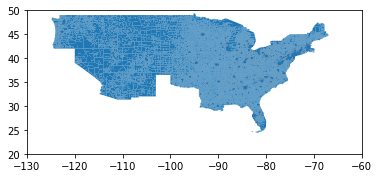

In [14]:
fig,ax = plt.subplots(1,1)
newtestgdf.plot(ax=ax)
plt.xlim(-130,-60)
plt.ylim(20,50)
plt.show()



## FLORIDA

### Get water areas etc for whole state

In [15]:
# s = time.time()

# this_state = 'FL'
# this_state_number = 12
# #this_state_number = state_codes_df[state_codes_df['STUSAB'] == this_state.upper()].index.values[0]

# if (debug >= 1):
#     print('reading area water shapefiles in {0:}...'.format(this_state))

# water_gdf = geopandas.GeoDataFrame()
# water_file_list = [shapefiledir+'AREAWATER/'+x for x in os.listdir(shapefiledir+'AREAWATER/') if ((x[-4:] == '.shp') and ('tl_2018_{0:02d}'.format(this_state_number) in x))]

# for i in range(0, len(water_file_list)):
#     if (debug >= 1):
#         if ((np.mod(i,10) == 0) | (i == len(water_file_list)-1)):
#             print('\tReading file {0:,.0f} of {1:,.0f}...'.format(i+1, len(water_file_list)))
#     water_gdf_i = geopandas.read_file(water_file_list[i])
#     #water_gdf_i = water_gdf_i[water_gdf_i['AWATER'] >= water_area_tol]
#     water_gdf = pandas.concat((water_gdf, water_gdf_i), axis=0, sort=False)

# water_gdf.loc[:, 'INTPTLON'] = pandas.to_numeric(water_gdf['INTPTLON'], errors='coerce')
# water_gdf.loc[:, 'INTPTLAT'] = pandas.to_numeric(water_gdf['INTPTLAT'], errors='coerce')
# water_gdf = water_gdf.set_index('HYDROID')
# e = time.time()
# g = g + (e-s)

# # if (debug >= 1):
# #     #print('Read {0:,.0f} bodies of water with area greater than or equal to {1:,.0f} km^2 in {2:,.0f} seconds!'.format(len(water_gdf), water_area_tol/(1000*1000), e-s))
# #     print('Read {0:,.0f} bodies of linear water in {1:,.0f} seconds!'.format(len(water_gdf), e-s))
# # #print(assembler_gdf.groupby(['STUSAB', 'block_based_district']).size())
# # s = time.time()

# if (debug >= 1):
#     print('reading place shapefiles in {0:}...'.format(this_state))

# place_gdf = geopandas.GeoDataFrame()
# place_file_list = [shapefiledir+'PLACE/'+x for x in os.listdir(shapefiledir+'PLACE/') if ((x[-4:] == '.shp') and ('tl_2018_{0:02d}'.format(this_state_number) in x))]

# for i in range(0, len(place_file_list)):
#     if (debug >= 1):
#         if ((np.mod(i,10) == 0) | (i == len(water_file_list)-1)):
#             print('\tReading file {0:,.0f} of {1:,.0f}...'.format(i+1, len(place_file_list)))
#     place_gdf_i = geopandas.read_file(place_file_list[i])
    
#     place_gdf = pandas.concat((place_gdf, place_gdf_i), axis=0, sort=False)

# place_gdf.loc[:, 'INTPTLON'] = pandas.to_numeric(place_gdf['INTPTLON'], errors='coerce')
# place_gdf.loc[:, 'INTPTLAT'] = pandas.to_numeric(place_gdf['INTPTLAT'], errors='coerce')

# place_gdf = place_gdf.set_index('GEOID')

# e = time.time()
# g = g + (e-s)

# if (debug >= 1):
#     #print('Read {0:,.0f} bodies of water with area greater than or equal to {1:,.0f} km^2 in {2:,.0f} seconds!'.format(len(water_gdf), water_area_tol/(1000*1000), e-s))
#     print('Read {0:,.0f} places in {1:,.1f} seconds!'.format(len(place_gdf), e-s))
# #place_gdf.head(1)

# s = time.time()

# if (debug >= 1):
#     print('reading roads shapefiles in {0:}...'.format(this_state))

# roads_gdf = geopandas.GeoDataFrame()
# roads_file_list = [shapefiledir+'ROADS/'+x for x in os.listdir(shapefiledir+'ROADS/') if ((x[-4:] == '.shp') and ('tl_2018_{0:02d}'.format(this_state_number) in x))]

# for i in range(0, len(roads_file_list)):
#     if (debug >= 1):
#         if ((np.mod(i,10) == 0) | (i == len(water_file_list)-1)):
#             print('\tReading file {0:,.0f} of {1:,.0f}...'.format(i+1, len(roads_file_list)))
#     roads_gdf_i = geopandas.read_file(roads_file_list[i])
    
#     roads_gdf = pandas.concat((roads_gdf, roads_gdf_i), axis=0, sort=False)

# roads_gdf = roads_gdf.set_index('LINEARID')

# # #roads_gdf.head(1).T
# # # Road Types: C = County, I = Interstate, M = Common name, O = Other, S = State hwy, U = US hwy

# old_map_buffer_ratio = -1

# e = time.time()
# g = g + (e-s)

# if (debug >= 1):
#     print('Read {0:,.0f} roads in {1:,.1f} seconds!'.format(len(roads_gdf), e-s))


## Define north and south Florida

### North Florida is all N of Indiantown and E of Alice Town, Bahamas
##### North of 27 deg North, west of -79.3 deg West



In [16]:
# s = time.time()
# nDistricts = 27
# print('making box...')

# north_florida_west_limit = unary_union(assembler_gdf[(assembler_gdf['STUSAB'] == this_state)].geometry.tolist()).bounds[0]
# north_florida_north_limit = unary_union(assembler_gdf[(assembler_gdf['STUSAB'] == this_state)].geometry.tolist()).bounds[3]
# north_florida_east_limit = -79.3
# north_florida_south_limit = 27

# xlim = [north_florida_west_limit, north_florida_east_limit]
# ylim = [north_florida_north_limit, north_florida_south_limit]

# north_florida_geo = makebox(xlim, ylim)

# print('splitting water...')
# water_north_florida_gdf = water_gdf[water_gdf.geometry.within(north_florida_geo)]
# water_south_florida_gdf = water_gdf[~water_gdf.geometry.within(north_florida_geo)]

# print('splitting places...')
# place_north_florida_gdf = place_gdf[place_gdf.geometry.within(north_florida_geo)]
# place_south_florida_gdf = place_gdf[~place_gdf.geometry.within(north_florida_geo)]


# print('splitting roads...')
# roads_north_florida_gdf = roads_gdf[roads_gdf.geometry.within(north_florida_geo)]
# roads_south_florida_gdf = roads_gdf[~roads_gdf.geometry.within(north_florida_geo)]


# e = time.time()
# g = g + (e-s)
# print('Defined North and South Florida areas in {0:,.0f} minutes {1:,.0f} seconds!'.format(np.floor((e-s)/60), np.floor((e-s)%60)))



### North Florida establishing shot

In [17]:
# s = time.time()
# print('plotting...')
# north_florida_geo_gdf = geopandas.GeoDataFrame(data=[[north_florida_geo]], columns=['geometry'], crs=assembler_gdf.crs, geometry='geometry')

# fig, ax = plt.subplots(1,1)



# for i in range(1, 19):#nDistricts+1):
#     cd_gdf[
#         (cd_gdf['STUSAB'] == this_state) & (cd_gdf['CD116FP'] == i)
#     ].plot(ax=ax, color=district_color_cycle[i-1])
#     annotator = i
#     centerpoint = cd_gdf[
#         (cd_gdf['STUSAB'] == this_state) & (cd_gdf['CD116FP'] == i)
#     ].geometry.apply(lambda x: (x.centroid.x, x.centroid.y)).values[0]
#     plt.annotate(annotator, centerpoint, 
#                  ha='center', va='center', fontsize=8,
#                  color='black', backgroundcolor='white')

# assembler_gdf[
#     (assembler_gdf['STUSAB'] == this_state)
#     & (assembler_gdf.geometry.apply(lambda x: x.within(north_florida_geo)))
# ].plot(ax=ax, color='None', edgecolor='black', lw=0.5)


# north_florida_geo_gdf.plot(ax=ax, color='none', edgecolor='black')

# plt.xlim(north_florida_west_limit, north_florida_east_limit)
# plt.ylim(north_florida_south_limit, north_florida_north_limit)

# plt.show()
# e = time.time()
# g = g + (e-s)
# print('Plotted North Florida area in {0:,.0f} minutes {1:,.0f} seconds!'.format(np.floor((e-s)/60), np.floor((e-s)%60)))


### South Florida establishing shot

In [18]:
# s = time.time()
# bitmask_shiftor = 17

# print('plotting...')

# north_florida_geo_gdf = geopandas.GeoDataFrame(data=[[north_florida_geo]], columns=['geometry'], crs=assembler_gdf.crs, geometry='geometry')

# fig, ax = plt.subplots(1,1)



# for i in range(17, nDistricts+1):
#     cd_gdf[
#         (cd_gdf['STUSAB'] == this_state) & (cd_gdf['CD116FP'] == i)
#     ].plot(ax=ax, color=district_color_cycle[np.mod(i,bitmask_shiftor+1)-3])
#     annotator = i
#     centerpoint = cd_gdf[
#         (cd_gdf['STUSAB'] == this_state) & (cd_gdf['CD116FP'] == i)
#     ].geometry.apply(lambda x: (x.centroid.x, x.centroid.y)).values[0]
#     plt.annotate(annotator, centerpoint, 
#                  ha='center', va='center', fontsize=8,
#                  color='black', backgroundcolor='white')

# assembler_gdf[
#     (assembler_gdf['STUSAB'] == this_state)
#     & (assembler_gdf.geometry.apply(lambda x: ~x.within(north_florida_geo)))
# ].plot(ax=ax, color='None', edgecolor='white', lw=0.5)


# #north_florida_geo_gdf.plot(ax=ax, color='none', edgecolor='black')

# # plt.xlim(north_florida_west_limit, north_florida_east_limit)
# # plt.ylim(north_florida_south_limit, north_florida_north_limit)

# plt.show()
# e = time.time()
# g = g + (e-s)
# print('Plotted South Florida area in {0:,.0f} minutes {1:,.0f} seconds!'.format(np.floor((e-s)/60), np.floor((e-s)%60)))


## North Florida matching

In [19]:
# color_reset_point = 17

# assembler_gdf.loc[['15000US120599603002'], 'block_based_district'] = 1
# assembler_gdf.loc[['15000US120599604001', '15000US120599604002', '15000US120599601001', '15000US120599603001'], 'block_based_district'] = 2
# assembler_gdf.loc[['15000US120830025021'], 'block_based_district'] = 3
# assembler_gdf.loc[['15000US120830025023', '15000US120830025024', '15000US120830025042', '15000US120830025043'], 'block_based_district'] = 2
# assembler_gdf.loc[['15000US120830025041', '15000US120830001001', '15000US120830026011'], 'block_based_district'] = 3
# assembler_gdf.loc[['15000US120652502003', '15000US120730026041', '15000US120730025071', '15000US120730026062', '15000US120730024081', '15000US120730023023', '15000US120730016022', '15000US120730016023', '15000US120730017001', '15000US120730024032', '15000US120730025053', '15000US120730022071'], 'block_based_district'] = 2
# assembler_gdf.loc[['15000US120730026031', '15000US120652502002', '15000US120730023022', '15000US120730024131', '15000US120730025082', '15000US120730025084', '15000US120730012001', '15000US120730025054', '15000US120730021031'], 'block_based_district'] = 5
# assembler_gdf.loc[['15000US120730002003', '15000US120730007001', '15000US120730007002', '15000US120730009011', '15000US120730009013', '15000US120730020042', '15000US120730020063', '15000US120231103002', '15000US120231102021', '15000US120231102023', '15000US120231108001', '15000US120730020062'], 'block_based_district'] = 2
# assembler_gdf.loc[['15000US120730006003', '15000US120730017002', '15000US120231103001'], 'block_based_district'] = 5
# assembler_gdf.loc[['15000US120231102024', '15000US120231105004', '15000US120231107004', '15000US120231108002'], 'block_based_district'] = 2
# assembler_gdf.loc[['15000US120231102022', '15000US120231103004', '15000US120231105002'], 'block_based_district'] = 5
# assembler_gdf.loc[['15000US120830027023'], 'block_based_district'] = 2
# assembler_gdf.loc[['15000US120830006012', '15000US120830023022', '15000US120830024021'], 'block_based_district'] = 3
# assembler_gdf.loc[['15000US120830006022', '15000US120830006023', '15000US120830024022', '15000US120830011031'], 'block_based_district'] = 11
# assembler_gdf.loc[['15000US120310173001', '15000US120310173004', '15000US120310103011', '15000US120310103012', '15000US120310104021', '15000US120310147021', '15000US120310106002', '15000US120310105005', '15000US120310119015', '15000US120310117001', '15000US120310119011', '15000US120310025022', '15000US120310118003', '15000US120310120002'], 'block_based_district'] = 4
# assembler_gdf.loc[['15000US120310103041', '15000US120310105001', '15000US120310171001', '15000US120310025013', '15000US120310105004', '15000US120310106003'], 'block_based_district'] = 5
# assembler_gdf.loc[['15000US120310131001', '15000US120310021012', '15000US120310021013', '15000US120310143371', '15000US120310143112', '15000US120310159231', '15000US120310166011', '15000US120310006001', '15000US120310162002', '15000US120310146031', '15000US120310157001', '15000US120310158012', '15000US120310161001'], 'block_based_district'] = 4
# assembler_gdf.loc[['15000US120310133002', '15000US120310025011', '15000US120310172001', '15000US120310006002', '15000US120310006004', '15000US120310007003', '15000US120310164001', '15000US120310146032', '15000US120310146033', '15000US120310146042'], 'block_based_district'] = 5
# assembler_gdf.loc[['15000US121099902000', '15000US121090214061'], 'block_based_district'] = 4
# assembler_gdf.loc[['15000US121090211012', '15000US121090214031', '15000US121090214062'], 'block_based_district'] = 6
# assembler_gdf.loc[['15000US120690310004', '15000US120690302072', '15000US120690302092', '15000US120690302071', '15000US120690303051'], 'block_based_district'] = 6
# assembler_gdf.loc[['15000US120690303063', '15000US120690309124', '15000US120690308071'], 'block_based_district'] = 11
# assembler_gdf.loc[['15000US120950166012', '15000US120950166021', '15000US120950166011'], 'block_based_district'] = 8
# assembler_gdf.loc[['15000US120950136031'], 'block_based_district'] = 7
# assembler_gdf.loc[['15000US120950167291', '15000US120950134032'], 'block_based_district'] = 7
# assembler_gdf.loc[['15000US120950134021', '15000US120950134031'], 'block_based_district'] = 9
# assembler_gdf.loc[['15000US120950139001', '15000US120950180002', '15000US120950152011', '15000US120950152012', '15000US120950188003', '15000US120950188004'], 'block_based_district'] = 7
# assembler_gdf.loc[['15000US120950140004', '15000US120950153001', '15000US120950153002', '15000US120950103003', '15000US120950185003', '15000US120950189005'], 'block_based_district'] = 10
# assembler_gdf.loc[['15000US120950167041', '15000US120950167301', '15000US120950167311'], 'block_based_district'] = 9
# assembler_gdf.loc[['15000US120950168021'], 'block_based_district'] = 9
# assembler_gdf.loc[['15000US120950170141'], 'block_based_district'] = 10
# assembler_gdf.loc[['15000US121050124111', '15000US121050124091', '15000US121050124051', '15000US121050117211', '15000US121050116043'], 'block_based_district'] = 9
# assembler_gdf.loc[['15000US121050124041', '15000US121050117212', '15000US121050116062', '15000US121050116051', '15000US121050116042', '15000US121050124071'], 'block_based_district'] = 15



# assembler_gdf.loc[['15000US121050157023', '15000US121050145014', '15000US121050147022'], 'block_based_district'] = 9
# assembler_gdf.loc[['15000US121050158021', '15000US121050153021', '15000US121050145021', '15000US121050145022', '15000US121050145011'], 'block_based_district'] = 17


# assembler_gdf.loc[['15000US120690313073', '15000US120690312051', '15000US120690313074', '15000US120690311031', '15000US120690312043', '15000US120690313012', '15000US120690313091', '15000US120690313092'], 'block_based_district'] = 11
# assembler_gdf.loc[['15000US120690312021', '15000US120690312023', '15000US120690313073', '15000US120690312042'], 'block_based_district'] = 15

# assembler_gdf.loc[['15000US121030271064', '15000US121030269124', '15000US121030267022'], 'block_based_district'] = 12
# assembler_gdf.loc[['15000US121039900000', '15000US121030268091', '15000US121030268092', '15000US121030268131'], 'block_based_district'] = 13

# assembler_gdf.loc[['15000US120570115041'], 'block_based_district'] = 12
# assembler_gdf.loc[['15000US120570115042', '15000US120570115221'], 'block_based_district'] = 14

# assembler_gdf.loc[['15000US120570120022', '15000US120570136021', '15000US120570136041'], 'block_based_district'] = 14
# assembler_gdf.loc[['15000US120570102131', '15000US120570108091', '15000US120570135031', '15000US120570135041', '15000US120570136022'], 'block_based_district'] = 15
# assembler_gdf.loc[['15000US120570131002'], 'block_based_district'] = 15
# assembler_gdf.loc[['15000US120570138011', '15000US120579900000', '15000US120570134131', '15000US120570139031'], 'block_based_district'] = 16
# assembler_gdf.loc[['15000US121050148022', '15000US121050118321', '15000US121050118322'], 'block_based_district'] = 17
# assembler_gdf.loc[['15000US121150020053', '15000US121150020091', '15000US121150019072'], 'block_based_district'] = 16
# assembler_gdf.loc[['15000US121150027133', '15000US121150021001', '15000US121150021002'], 'block_based_district'] = 17

# if ('bitmask_north' not in assembler_gdf.columns):
#     assembler_gdf = assembler_gdf.assign(bitmask_north = np.nan)

# assembler_gdf.loc[
#     (assembler_gdf['STUSAB'] == this_state)
#     & (assembler_gdf['block_based_district'] == -1)
#     & (assembler_gdf.geometry.apply(lambda x: x.within(north_florida_geo)))
# , 'bitmask_north'] = assembler_gdf[
#     (assembler_gdf['STUSAB'] == this_state)
#     & (assembler_gdf['block_based_district'] == -1)
#     & (assembler_gdf.geometry.apply(lambda x: x.within(north_florida_geo)))
# ]['congressional_districts_bitmask'].apply(lambda x: x[:19])

# assembler_gdf[
#     (assembler_gdf['STUSAB'] == this_state) 
#     & (assembler_gdf['block_based_district'] == -1)
# ].groupby('bitmask_north').size().sort_index(ascending=False)


## NORTH FLORIDA: Examine and match

In [20]:
# s = time.time()

# this_state = 'FL'
# test_bitmask_north = 'x000000000000000110'

# manual_plot_limits = False
# show_small_roads = True
# show_places = False
# show_water = True

# # 16 vs 17
# manual_xlim = (-82.53,-82.43)
# manual_ylim = (27.16,27.26)

# legend_location = 'upper left'

# map_buffer_ratio = .1

# fig, (ax1, ax2) = plt.subplots(1,2,figsize=(16,8))
# #fig, (ax1, ax2) = plt.subplots(2,1,figsize=(16,8))

# print('Plotting official districts...')
# for ax in (ax1, ax2):
#     legend_list = []
#     for i in range(1, len(test_bitmask_north)):
#         if (test_bitmask_north[i] == '1'):
#             cd_gdf[
#                 (cd_gdf['STUSAB'] == this_state) 
#                 & (cd_gdf['CD116FP'] == i)
#             ].plot(ax=ax, color=district_color_cycle[i-1])
#             legend_list.append(mpatches.Patch(color=district_color_cycle[i-1], label='District {0:,.0f}'.format(i)))
#     ax.legend(handles=legend_list, fontsize=12, loc=legend_location)

#     assembler_gdf[
#         (assembler_gdf['block_based_district'] == -1)
#         & (assembler_gdf['bitmask_north'] == test_bitmask_north)
#     ].plot(ax=ax, color='none', edgecolor='yellow', linewidth=4)    

#     if (manual_plot_limits):
#         xlimits = (manual_xlim[0], manual_xlim[1])
#         ylimits = (manual_ylim[0], manual_ylim[1])
#     else:
#         bounding_box = unary_union(
#                 assembler_gdf[
#                     (assembler_gdf['block_based_district'] == -1)
#                     & (assembler_gdf['bitmask_north'] == test_bitmask_north)
#             ].geometry.tolist()
#         ).bounds
#         xlimits = (bounding_box[0], bounding_box[2])
#         ylimits = (bounding_box[1], bounding_box[3])
 
#     xspan = xlimits[1] - xlimits[0]
#     yspan = ylimits[1] - ylimits[0]
#     xbuffer = xspan * map_buffer_ratio
#     ybuffer = yspan * map_buffer_ratio
    
#     ax.set_xlim(xlimits[0] - xbuffer, xlimits[1] + xbuffer)
#     ax.set_ylim(ylimits[0] - ybuffer, ylimits[1] + ybuffer)

# print('labeling block groups...')
# #####  add labels for block groups with overlap
# b = []
# for ix, thisrow in assembler_gdf[
#     (assembler_gdf['block_based_district'] == -1)
#     & (assembler_gdf['bitmask_north'] == test_bitmask_north)
#     & ((assembler_gdf['INTPTLON'] >= xlimits[0]) & (assembler_gdf['INTPTLON'] <= xlimits[1]))
#     & ((assembler_gdf['INTPTLAT'] >= ylimits[0]) & (assembler_gdf['INTPTLAT'] <= ylimits[1]))
# ].iterrows():
#     b.append(ix)
#     annotator = ix[-6:]
#     ax1.annotate(annotator, 
#                      (float(thisrow['INTPTLON']), float(thisrow['INTPTLAT'])),
#                      (float(thisrow['INTPTLON']), float(thisrow['INTPTLAT'])),
#                  color='black', backgroundcolor='white', fontsize=10, ha='center'
#                )
# b = sorted(b)
# for i in range(0,len(b)):
#     print(b[i])

# if (show_water):
#     print('plotting water...')
#     water_north_florida_gdf.plot(ax=ax2, color='blue')
    
# print('plotting roads...')
# if (show_small_roads):
#     roads_north_florida_gdf[roads_north_florida_gdf['RTTYP'].isnull()].plot(ax=ax2, color=road_label_format['O']['thecolor'], linewidth=0.25)
#     roads_north_florida_gdf[~roads_north_florida_gdf['RTTYP'].isin(['I','U','S','C'])].plot(ax=ax2, color=road_label_format['M']['thecolor'], linewidth=0.25)

# roads_north_florida_gdf[roads_north_florida_gdf['RTTYP'] == 'C'].plot(ax=ax2, color=road_label_format['C']['thecolor'], linewidth=0.5)
# roads_north_florida_gdf[roads_north_florida_gdf['RTTYP'] == 'S'].plot(ax=ax2, color=road_label_format['S']['thecolor'], linewidth=1)
# roads_north_florida_gdf[roads_north_florida_gdf['RTTYP'] == 'U'].plot(ax=ax2, color=road_label_format['U']['thecolor'], linewidth=1.5)
# roads_north_florida_gdf[roads_north_florida_gdf['RTTYP'] == 'I'].plot(ax=ax2, color=road_label_format['I']['thecolor'], linewidth=4)

# if (show_places):
#     print('plotting places...')
#     place_gdf.plot(ax=ax, color='none', edgecolor='yellow', linewidth=3)
#     for ix, thisrow in place_gdf[
#         ((place_gdf['INTPTLON'] >= xlimits[0] - xbuffer) & (place_gdf['INTPTLON'] <= xlimits[1] + xbuffer))
#         & ((place_gdf['INTPTLAT'] >= ylimits[0] - ybuffer) & (place_gdf['INTPTLAT'] <= ylimits[1] + ybuffer))
#     ].sort_values(by='NAME').iterrows():
#         print('\t{0:}...'.format(thisrow['NAME']))
#         annotator = thisrow['NAME'].upper()
#         ax2.annotate(annotator, 
#                          (float(thisrow['INTPTLON']), float(thisrow['INTPTLAT'])),
#                          (float(thisrow['INTPTLON']), float(thisrow['INTPTLAT'])),
#                      color='black', backgroundcolor='white', fontsize=10, ha='center'
#                    )

# explore_more = b
# oldi = -1
# old_map_bufer_ratio = -1
# plt.show()

# e = time.time()
# g = g + (e-s)
# print('Done in {0:,.0f} minutes {1:,.0f} seconds!'.format(np.floor((e-s)/60), np.floor((e-s)%60)))
# plt.show()



### Examine one district at a time in more detail

In [21]:

# s = time.time()
# #explore_more = ['15000US121030271064']

# label_small_roads = True
# label_small_road_types = []
# show_places = False
# show_water = True
# basesize = 12
# aspect_ratio = xspan / yspan
# #oldi = -1

# i = 2

# map_buffer_ratio = .1

# suffixes_to_count_dict = {'Rd': 0, 'Dr': 0, 'St': 0,'Ave': 0, 'Blvd': 0, 'Ln': 0, 'Cir': 0, 'Way': 0, 'Ct': 0, 'Pkwy': 0, 'Pl': 0, 'NW': 0, 'NE': 0, 'SW': 0, 'SE': 0 }
# other_roads = []


# if (oldi != i):
#     print('Running this cell for the first time...')
# this_block_group_id = explore_more[i]

# #this_block_group_id = '15000US360471192003'

# print('Examining block group {0:}'.format(this_block_group_id))
# print('Population: {0:,.0f}'.format(assembler_gdf.loc[this_block_group_id]['total_population']))

# block_group_gdf = assembler_gdf[assembler_gdf.index == this_block_group_id]

# total_block_group_area = assembler_gdf[assembler_gdf.index == this_block_group_id].to_crs(equal_area_crs).geometry.apply(lambda x: x.area).values[0]
# print('Area: {0:,.1f} km^2'.format(total_block_group_area/1000000))

# xlimits = block_group_gdf.geometry.apply(lambda x: (x.bounds[0], x.bounds[2])).values[0]
# ylimits = block_group_gdf.geometry.apply(lambda x: (x.bounds[1], x.bounds[3])).values[0]

# xspan = xlimits[1] - xlimits[0]
# yspan = ylimits[1] - ylimits[0]
# aspect_ratio = xspan / yspan

# xbuffer = xspan * map_buffer_ratio
# ybuffer = yspan * map_buffer_ratio

# xlimits = block_group_gdf.geometry.apply(lambda x: (x.bounds[0] - xbuffer, x.bounds[2] + xbuffer)).values[0]
# ylimits = block_group_gdf.geometry.apply(lambda x: (x.bounds[1] - ybuffer, x.bounds[3] + ybuffer)).values[0]


# if ((oldi != i) | (old_map_buffer_ratio != map_buffer_ratio)):
#     map_area_geo = makebox(xlimits, ylimits)

# map_area_gdf = geopandas.GeoDataFrame(data=[[map_area_geo]], columns=['geometry'], crs=block_group_gdf.crs, geometry='geometry')

# print('Aspect ratio: {0:.3f}'.format(aspect_ratio))
# print('\n')

# fig, ax = plt.subplots(1,1,figsize=(basesize*aspect_ratio,basesize))

# legend_list = []
# for j in range(1, len(test_bitmask_north)):
#     if (test_bitmask_north[j] == '1'):
#         print('Matching District {0:}...'.format(j))
#         legend_list.append(mpatches.Patch(color=district_color_cycle[j-1], label='District {0:,.0f}'.format(j)))
#         cd_gdf[(cd_gdf['STUSAB'] == this_state) & (cd_gdf['CD116FP'] == j)].plot(ax=ax, color=district_color_cycle[j-1])
#         overlap_area = geopandas.overlay(block_group_gdf.to_crs(equal_area_crs), cd_gdf[(cd_gdf['STUSAB'] == this_state) & (cd_gdf['CD116FP'] == j)].to_crs(equal_area_crs), how='intersection').area.values[0]
#         print('\tOverlap area: {0:,.1f} km^2 ({1:.1%})'.format(overlap_area / 1000000, overlap_area / total_block_group_area))
            
            
# print('\n')



# block_group_gdf.plot(ax=ax, color='none', edgecolor='white', lw=10, zorder=100)
# map_area_gdf.plot(ax=ax, color='none', edgecolor='orange', lw=16)

# print('finding water overlap...')
# if ((oldi != i) | (old_map_buffer_ratio != map_buffer_ratio)):
#     water_in_map_area_gdf = water_north_florida_gdf[water_north_florida_gdf.geometry.apply(lambda x: x.intersects(map_area_geo))]
#     #water_here_gdf = geopandas.overlay(water_gdf, block_group_gdf, how='intersection')
# water_in_map_area_gdf.plot(ax=ax, color='blue')

# print('finding road overlap...')
# if ((oldi != i) | (old_map_buffer_ratio != map_buffer_ratio)):
#     print('\twith block group...')
#     roads_in_block_group_gdf = roads_north_florida_gdf[roads_north_florida_gdf.geometry.apply(lambda x: x.intersects(block_group_gdf.geometry.values[0]))]
#     print('\twith full map area...')
#     roads_in_map_area_gdf = roads_north_florida_gdf[roads_north_florida_gdf.geometry.apply(lambda x: x.intersects(map_area_geo))]


# roads_in_map_area_gdf[roads_in_map_area_gdf['RTTYP'].isnull()].plot(ax=ax, color='red', linewidth=0.5) 
# roads_in_map_area_gdf[roads_in_map_area_gdf['RTTYP'].isin(['M', 'O'])].plot(ax=ax, color='black', linewidth=1) 
# roads_in_map_area_gdf[roads_in_map_area_gdf['RTTYP'] == 'C'].plot(ax=ax, color='black', linewidth=2)
# roads_in_map_area_gdf[roads_in_map_area_gdf['RTTYP'] == 'S'].plot(ax=ax, color='black', linewidth=3)
# roads_in_map_area_gdf[roads_in_map_area_gdf['RTTYP'] == 'U'].plot(ax=ax, color='black', linewidth=4)
# roads_in_map_area_gdf[roads_in_map_area_gdf['RTTYP'] == 'I'].plot(ax=ax, color='orange', linewidth=5)


# print('labeling big roads in map area...')
# for ix, thisrow in roads_in_map_area_gdf[
#     (roads_in_map_area_gdf['FULLNAME'].notnull()) 
#     & (roads_in_map_area_gdf['RTTYP'].isin(['I', 'U', 'S', 'C']))].iterrows():
#     annotator = parse_road_name(thisrow['FULLNAME'])
#     centerpoint = Point((thisrow.geometry.centroid.x, thisrow.geometry.centroid.y))
#     if (map_area_geo.contains(centerpoint)):
#         plt.annotate(annotator, (thisrow.geometry.centroid.x, thisrow.geometry.centroid.y), (thisrow.geometry.centroid.x, thisrow.geometry.centroid.y), 
#                      color='black', backgroundcolor='white', ha='center', va='center',
#                      fontsize=road_label_format[thisrow['RTTYP']]['labelsize'], bbox=road_label_format[thisrow['RTTYP']]['thebbox'])
    
# if (label_small_roads):    
#     print('labeling small roads in block group...')
#     for ix, thisrow in roads_in_block_group_gdf[(roads_in_block_group_gdf['FULLNAME'].notnull()) & (roads_in_block_group_gdf['RTTYP'].isin(['M', 'O']))].iterrows():
#         #print('\t{0:}'.format(thisrow['FULLNAME']))
#         is_other_road_type = False
#         try:
#             road_suffix = thisrow['FULLNAME'][::-1][:re.search("\s",thisrow['FULLNAME'][::-1]).start()][::-1].strip()
#             if (road_suffix in suffixes_to_count_dict):
#                 suffixes_to_count_dict[road_suffix] = suffixes_to_count_dict[road_suffix] + 1
#         except AttributeError:
#             is_other_road_type = True 
#             other_roads.append(thisrow['FULLNAME'])
        
#         if ((road_suffix in label_small_road_types) | (is_other_road_type)):
#             annotator = thisrow['FULLNAME']            
#             plt.annotate(annotator, (thisrow.geometry.centroid.x, thisrow.geometry.centroid.y), (thisrow.geometry.centroid.x, thisrow.geometry.centroid.y), 
#                  color='black', backgroundcolor='white', fontsize=road_label_format[thisrow['RTTYP']]['labelsize'], ha='center', va='center')


# plt.title("Block Group {0:}".format(this_block_group_id), fontsize=24)

# if (label_small_roads):
#     print("\tAnalysis of road names:")
#     for k,v in suffixes_to_count_dict.items():
#         print('\t\t{0:}: {1:,.0f}'.format(k,v))
#     print('\tOther road names:')
#     for x in other_roads:
#         print('\t\t',x)
#     print('\n')

# if (show_places):
#     print('finding places...')
#     print('\tshowing place names...')
#     for ix, thisrow in place_north_florida_gdf.iterrows():
#         if (thisrow.geometry.intersects(assembler_gdf.loc[this_block_group_id].geometry)):
#             print('\t\t',str(thisrow['NAME']))
#     print('\tplotting places...')    
#     place_north_florida_gdf.plot(ax=ax, color='none', edgecolor='cyan', lw=5)
#     print('\tlabeling places...')
    

#     for ix, thisrow in place_north_florida_gdf[
#         ((place_north_florida_gdf['INTPTLON'] >= xlimits[0] - xbuffer) & (place_north_florida_gdf['INTPTLON'] <= xlimits[1] + xbuffer))
#         & ((place_north_florida_gdf['INTPTLAT'] >= ylimits[0] - ybuffer) & (place_north_florida_gdf['INTPTLAT'] <= ylimits[1] + ybuffer))
#     ].iterrows():
#         annotator = thisrow['NAME'].upper()
#         plt.annotate(annotator, (thisrow.geometry.centroid.x, thisrow.geometry.centroid.y), (thisrow.geometry.centroid.x, thisrow.geometry.centroid.y), 
#                  color='black', backgroundcolor='white', fontsize=16, ha='center', va='center')


# print('http://maps.google.com/maps?ll={1:.3f},{0:.3f}&spn={2:.3f},{3:.3f}&t=m'.format((xlimits[0]+xlimits[1])/2, (ylimits[0]+ylimits[1])/2, xspan, yspan))

# ax.legend(handles=legend_list, fontsize=12, loc=legend_location)
# plt.xlim(xlimits)
# plt.ylim(ylimits)

# # plt.xticks(fontsize=24)
# # plt.yticks(fontsize=24)


# plt.show()




# oldi = i
# old_map_buffer_ratio = map_buffer_ratio

# e = time.time()
# g = g + (e-s)
# print('Done in {0:,.0f} minutes {1:,.0f} seconds!'.format(np.floor((e-s)/60), np.floor((e-s)%60)))

# #map_area_geo
# if (label_small_roads):
#     pprint(suffixes_to_count_dict)
#     print(other_roads)
# pprint(this_block_group_id)



### Check whether the block-based districts match official districts

In [22]:
# s = time.time()
# this_state = 'FL'
# nDistricts = 27

# thedistricts = [14,15]

# manual_xlim = (-82.48,-82.26)
# manual_ylim = (27.85,28.15)

# legend_location = 'lower right'

# map_buffer_ratio = .05

# fig, (ax1, ax2) = plt.subplots(1,2,figsize=(16,8))
# #fig, (ax1, ax2) = plt.subplots(2,1,figsize=(16,8))

# print('plotting block-group-based districts...')
# for ax in (ax1,ax2):
#     legend_list = []
#     for i in thedistricts:
#         print(i)
#         assembler_gdf[
#             (assembler_gdf['STUSAB'] == this_state)
#             & (assembler_gdf['block_based_district'] == i)
#         ].plot(ax=ax, color=district_color_cycle[i-1], edgecolor='black', lw=0.25)
#         legend_list.append(mpatches.Patch(color=district_color_cycle[i-1], label='District {0:,.0f}'.format(i)))
    
#     ax.legend(handles=legend_list, fontsize=14, loc=legend_location)

#     #cd_gdf[(cd_gdf['STUSAB'] == this_state) & (cd_gdf['CD116FP'].isin(thedistricts))].plot(ax=ax, color='none', edgecolor='cyan', lw=3)
    
#     xlimits = (manual_xlim[0], manual_xlim[1])
#     ylimits = (manual_ylim[0], manual_ylim[1])
    
#     ax.set_xlim(xlimits)
#     ax.set_ylim(ylimits)



# # print('labeling block groups...')
# # #####  add labels for block groups with overlap
# # b = []
# # for ix, thisrow in assembler_gdf[
# #     (assembler_gdf['STUSAB'] == this_state) 
# #     & ((assembler_gdf['INTPTLON'] >= xlimits[0]) & (assembler_gdf['INTPTLON'] <= xlimits[1]))
# #     & ((assembler_gdf['INTPTLAT'] >= ylimits[0]) & (assembler_gdf['INTPTLAT'] <= ylimits[1]))
# # ].iterrows():
# #     b.append(ix)
# #     annotator = ix[-6:]
# #     ax1.annotate(annotator, 
# #                      (float(thisrow['INTPTLON']), float(thisrow['INTPTLAT'])),
# #                      (float(thisrow['INTPTLON']), float(thisrow['INTPTLAT'])),
# #                  color='black', backgroundcolor='white', fontsize=10, ha='center', zorder=1000
# #                )

# print('plotting water...')    
# water_north_florida_gdf[
#     (water_north_florida_gdf.geometry.apply(lambda x: x.centroid.x >= xlimits[0])) & ((water_north_florida_gdf.geometry.apply(lambda x: x.centroid.x) <= xlimits[1]))
#     & (water_north_florida_gdf.geometry.apply(lambda x: x.centroid.y >= ylimits[0])) & ((water_north_florida_gdf.geometry.apply(lambda x: x.centroid.y) <= ylimits[1]))
# ].plot(ax=ax2, color='blue')

# # b = sorted(b)
# # for i in range(0,len(b)):
# #     print(b[i])

# plt.show()


## SOUTH FLORIDA

In [23]:
# assembler_gdf.loc[['15000US121159900000', '15000US120710402061', '15000US120710401262', '15000US120710401261', '15000US120710403053'], 'block_based_district'] = 17
# assembler_gdf.loc[['15000US120710201011', '15000US120710201012', '15000US120710201013', '15000US120710201021', '15000US120710201023', '15000US120710206003', '15000US120710206005', '15000US120710208006'], 'block_based_district'] = 17
# assembler_gdf.loc[['15000US120710403141', '15000US120710403054', '15000US120710004012'], 'block_based_district'] = 19
# assembler_gdf.loc[['15000US120990079121'], 'block_based_district'] = 20
# assembler_gdf.loc[['15000US120990078393', '15000US120990078361'], 'block_based_district'] = 18
# assembler_gdf.loc[['15000US120990078081', '15000US120990078091'], 'block_based_district'] = 20
# assembler_gdf.loc[['15000US120990078332', '15000US120990009031', '15000US120990010031', '15000US120990010045', '15000US120990019081'], 'block_based_district'] = 18
# assembler_gdf.loc[['15000US120990078131', '15000US120990078331', '15000US120990078321', '15000US120990011011', '15000US120990013012', '15000US120990013013', '15000US120990010021',  '15000US120990018023', '15000US120990019071'], 'block_based_district'] = 20
# assembler_gdf.loc[['15000US120119800001', '15000US120999804001', '15000US120990078181'], 'block_based_district'] = 20  # Found on second run
# assembler_gdf.loc[['15000US120999900000'], 'block_based_district'] = 21
# assembler_gdf.loc[['15000US120219900000', '15000US120210111061', '15000US120210106061', '15000US120210106051', '15000US120210106052', '15000US120210106053'], 'block_based_district'] = 19
# assembler_gdf.loc[['15000US120210104053', '15000US120210104054', '15000US120210104182', '15000US120210105063', '15000US120210106021', '15000US120210106062'], 'block_based_district'] = 25
# assembler_gdf.loc[['15000US120990077601', '15000US120990077632', '15000US120990039021', '15000US120990040051', '15000US120990040112', '15000US120990040113', '15000US120990038001', '15000US120990038002', '15000US120990038003'], 'block_based_district'] = 20
# assembler_gdf.loc[['15000US120990077211', '15000US120990077132', '15000US120990077531', '15000US120990077351', '15000US120990077051', '15000US120990040072', '15000US120990033002', '15000US120990037003'], 'block_based_district'] = 21
# assembler_gdf.loc[['15000US120990016001', '15000US120990016002', '15000US120990017001', '15000US120990017002', '15000US120990017004'], 'block_based_district'] = 20
# assembler_gdf.loc[['15000US120990020061', '15000US120990027001', '15000US120990028001', '15000US120990005111', '15000US120990005112', '15000US120990023001', '15000US120990023002'], 'block_based_district'] = 21
# assembler_gdf.loc[['15000US120110204043', '15000US120110204073', '15000US120110430021', '15000US120110428001', '15000US120110416001', '15000US120110425003', '15000US120110408012', '15000US120110417001', '15000US120110502071', '15000US120110205021', '15000US120110502083', '15000US120110303024'], 'block_based_district'] = 20
# assembler_gdf.loc[['15000US120110203181', '15000US120110430023', '15000US120110427002', '15000US120110427001', '15000US120110430026', '15000US120110426002', '15000US120110426003', '15000US120110509005', '15000US120110504022', '15000US120110408022', '15000US120110408021', '15000US120110502043', '15000US120110505021'], 'block_based_district'] = 22
# assembler_gdf.loc[['15000US120110306002', '15000US120110308011', '15000US120110308013', '15000US120110308014', '15000US120110502042', '15000US120110502061'], 'block_based_district'] = 20
# assembler_gdf.loc[['15000US120110302021', '15000US120110305001', '15000US120110306003', '15000US120110310011', '15000US120110501003'], 'block_based_district'] = 22
# assembler_gdf.loc[['15000US120111104041', '15000US120110602031', '15000US120110602061', '15000US120110413003', '15000US120110413004', '15000US120110429003', '15000US120110429004'], 'block_based_district'] = 20
# assembler_gdf.loc[['15000US120110703171', '15000US120111103242', '15000US120110703211', '15000US120110601204', '15000US120110601163', '15000US120110607001'], 'block_based_district'] = 23
# assembler_gdf.loc[['15000US120990069061', '15000US120990069062', '15000US120990069111', '15000US120990070052', '15000US120990070053'], 'block_based_district'] = 21
# assembler_gdf.loc[['15000US120990070072', '15000US120990070051'], 'block_based_district'] = 22
# assembler_gdf.loc[['15000US120119900000', '15000US120111106002', '15000US120110433021', '15000US120110430011', '15000US120110611001', '15000US120110611002', '15000US120110611003'], 'block_based_district'] = 22
# assembler_gdf.loc[['15000US120111106003', '15000US120110802001'], 'block_based_district'] = 23


# assembler_gdf.loc[['15000US120110908021', '15000US120860038014'], 'block_based_district'] = 23
# assembler_gdf.loc[['15000US120110909003', '15000US120110909004', '15000US120860001091', '15000US120860001202'], 'block_based_district'] = 24

# assembler_gdf.loc[['15000US120869900000'], 'block_based_district'] = 27

# assembler_gdf.loc[['15000US120860005052'], 'block_based_district'] = 24

# assembler_gdf.loc[['15000US120860120001', '15000US120860121006', '15000US120860121005'], 'block_based_district'] = 25


# assembler_gdf.loc[['15000US120860005033', '15000US120860009013', '15000US120860009023', '15000US120860009032', '15000US120860009033', '15000US120860017011', '15000US120860017013', '15000US120860017014'], 'block_based_district'] = 24

# assembler_gdf.loc[['15000US120860017031', '15000US120860017033'], 'block_based_district'] = 25

# assembler_gdf.loc[['15000US120860013011', '15000US120860036011', '15000US120860037024', '15000US120860037061'], 'block_based_district'] = 24
# assembler_gdf.loc[['15000US120860039121', '15000US120860039161', '15000US120860030042', '15000US120860037025', '15000US120860037041', '15000US120860037071'], 'block_based_district'] = 27

# assembler_gdf.loc[['15000US120860115003'], 'block_based_district'] = 26

# assembler_gdf.loc[['15000US120869805001'], 'block_based_district'] = 25

# assembler_gdf.loc[['15000US120860049011', '15000US120860050011', '15000US120860050013', '15000US120860050016'], 'block_based_district'] = 27


# assembler_gdf.loc[['15000US120869801001', '15000US120860087022', '15000US120860193001', '15000US120860194002', '15000US120860192002', '15000US120860106171', '15000US120869806001', '15000US120860106092', '15000US120860106093'], 'block_based_district'] = 26
# assembler_gdf.loc[['15000US120860086023', '15000US120860083044', '15000US120860102071', '15000US120860083043', '15000US120860106094'], 'block_based_district'] = 27

# assembler_gdf[
#     (assembler_gdf['STUSAB'] == this_state)
#     & (assembler_gdf['block_based_district'] == -1)
# ].groupby('congressional_districts_bitmask').size().sort_index(ascending=False)


### South Florida: examine and match

In [24]:
# s = time.time()

# this_state = 'FL'
# test_this_bitmask = 'x000000000000000000000000011'

# manual_plot_limits = False
# show_small_roads = True
# show_places = False
# show_water = True

# # 26 vs 27 all
# manual_xlim = (-80.44,-80.14)
# manual_ylim = (25.33,25.75)

# legend_location = 'upper right'

# map_buffer_ratio = .05

# fig, (ax1, ax2) = plt.subplots(1,2,figsize=(16,8))
# #fig, (ax1, ax2) = plt.subplots(2,1,figsize=(16,8))

# print('Plotting official districts...')
# for ax in (ax1, ax2):
#     legend_list = []
#     for i in range(1, len(test_this_bitmask)):
#         if (test_this_bitmask[i] == '1'):
#             cd_gdf[
#                 (cd_gdf['STUSAB'] == this_state) 
#                 & (cd_gdf['CD116FP'] == i)
#             ].plot(ax=ax, color=district_color_cycle[np.mod(i, color_reset_point+1)-1])
#             legend_list.append(mpatches.Patch(color=district_color_cycle[np.mod(i, color_reset_point+1)-1], label='District {0:,.0f}'.format(i)))
#     ax.legend(handles=legend_list, fontsize=12, loc=legend_location)

#     assembler_gdf[
#         (assembler_gdf['block_based_district'] == -1)
#         & (assembler_gdf['congressional_districts_bitmask'] == test_this_bitmask)
#     ].plot(ax=ax, color='none', edgecolor='purple', linewidth=4)    

#     if (manual_plot_limits):
#         xlimits = (manual_xlim[0], manual_xlim[1])
#         ylimits = (manual_ylim[0], manual_ylim[1])
#     else:
#         bounding_box = unary_union(
#                 assembler_gdf[
#                     (assembler_gdf['block_based_district'] == -1)
#                     & (assembler_gdf['congressional_districts_bitmask'] == test_this_bitmask)
#             ].geometry.tolist()
#         ).bounds
#         xlimits = (bounding_box[0], bounding_box[2])
#         ylimits = (bounding_box[1], bounding_box[3])
 
#     xspan = xlimits[1] - xlimits[0]
#     yspan = ylimits[1] - ylimits[0]
#     xbuffer = xspan * map_buffer_ratio
#     ybuffer = yspan * map_buffer_ratio
    
#     ax.set_xlim(xlimits[0] - xbuffer, xlimits[1] + xbuffer)
#     ax.set_ylim(ylimits[0] - ybuffer, ylimits[1] + ybuffer)

# print('labeling block groups...')
# #####  add labels for block groups with overlap
# b = []
# for ix, thisrow in assembler_gdf[
#     (assembler_gdf['block_based_district'] == -1)
#     & (assembler_gdf['congressional_districts_bitmask'] == test_this_bitmask)
#     & ((assembler_gdf['INTPTLON'] >= xlimits[0]) & (assembler_gdf['INTPTLON'] <= xlimits[1]))
#     & ((assembler_gdf['INTPTLAT'] >= ylimits[0]) & (assembler_gdf['INTPTLAT'] <= ylimits[1]))
# ].iterrows():
#     b.append(ix)
#     annotator = ix[-6:]
#     ax1.annotate(annotator, 
#                      (float(thisrow['INTPTLON']), float(thisrow['INTPTLAT'])),
#                      (float(thisrow['INTPTLON']), float(thisrow['INTPTLAT'])),
#                  color='black', backgroundcolor='white', fontsize=10, ha='center'
#                )
# b = sorted(b)
# for i in range(0,len(b)):
#     print(b[i])

# if (show_water):
#     print('plotting water...')
#     water_south_florida_gdf.plot(ax=ax2, color='blue')
    
# print('plotting roads...')
# if (show_small_roads):
#     roads_south_florida_gdf[roads_south_florida_gdf['RTTYP'].isnull()].plot(ax=ax2, color=road_label_format['O']['thecolor'], linewidth=0.25)
#     roads_south_florida_gdf[~roads_south_florida_gdf['RTTYP'].isin(['I','U','S','C'])].plot(ax=ax2, color=road_label_format['M']['thecolor'], linewidth=0.25)

# roads_south_florida_gdf[roads_south_florida_gdf['RTTYP'] == 'C'].plot(ax=ax2, color=road_label_format['C']['thecolor'], linewidth=0.5)
# roads_south_florida_gdf[roads_south_florida_gdf['RTTYP'] == 'S'].plot(ax=ax2, color=road_label_format['S']['thecolor'], linewidth=1)
# roads_south_florida_gdf[roads_south_florida_gdf['RTTYP'] == 'U'].plot(ax=ax2, color=road_label_format['U']['thecolor'], linewidth=1.5)
# roads_south_florida_gdf[roads_south_florida_gdf['RTTYP'] == 'I'].plot(ax=ax2, color=road_label_format['I']['thecolor'], linewidth=4)

# if (show_places):
#     print('plotting places...')
#     place_south_florida_gdf.plot(ax=ax, color='none', edgecolor='red', linewidth=3)
#     for ix, thisrow in place_south_florida_gdf[
#         ((place_gdf['INTPTLON'] >= xlimits[0] - xbuffer) & (place_gdf['INTPTLON'] <= xlimits[1] + xbuffer))
#         & ((place_gdf['INTPTLAT'] >= ylimits[0] - ybuffer) & (place_gdf['INTPTLAT'] <= ylimits[1] + ybuffer))
#     ].sort_values(by='NAME').iterrows():
#         print('\t{0:}...'.format(thisrow['NAME']))
#         annotator = thisrow['NAME'].upper()
#         ax2.annotate(annotator, 
#                          (float(thisrow['INTPTLON']), float(thisrow['INTPTLAT'])),
#                          (float(thisrow['INTPTLON']), float(thisrow['INTPTLAT'])),
#                      color='red', backgroundcolor='white', fontsize=10, ha='center'
#                    )

# explore_more = b
# oldi = -1
# old_map_bufer_ratio = -1
# plt.show()

# e = time.time()
# g = g + (e-s)
# print('Done in {0:,.0f} minutes {1:,.0f} seconds!'.format(np.floor((e-s)/60), np.floor((e-s)%60)))
# plt.show()



### Look at single block groups in more detail

In [25]:


# s = time.time()
# #explore_more = ['15000US120110602061']

# label_small_roads = True
# label_small_road_types = ['St','Ave','Blvd']
# show_places = True
# show_water = True
# basesize = 12
# aspect_ratio = xspan / yspan
# #oldi = -1

# i = 0

# map_buffer_ratio = .5

# suffixes_to_count_dict = {'Rd': 0, 'Dr': 0, 'St': 0,'Ave': 0, 'Blvd': 0, 'Ln': 0, 'Cir': 0, 'Way': 0, 'Ct': 0, 'Pkwy': 0, 'Pl': 0, 'NW': 0, 'NE': 0, 'SW': 0, 'SE': 0 }
# other_roads = []


# if (oldi != i):
#     print('Running this cell for the first time...')
# this_block_group_id = explore_more[i]

# #this_block_group_id = '15000US360471192003'

# print('Examining block group {0:}'.format(this_block_group_id))
# print('Population: {0:,.0f}'.format(assembler_gdf.loc[this_block_group_id]['total_population']))

# block_group_gdf = assembler_gdf[assembler_gdf.index == this_block_group_id]

# total_block_group_area = assembler_gdf[assembler_gdf.index == this_block_group_id].to_crs(equal_area_crs).geometry.apply(lambda x: x.area).values[0]
# print('Area: {0:,.1f} km^2'.format(total_block_group_area/1000000))

# xlimits = block_group_gdf.geometry.apply(lambda x: (x.bounds[0], x.bounds[2])).values[0]
# ylimits = block_group_gdf.geometry.apply(lambda x: (x.bounds[1], x.bounds[3])).values[0]

# xspan = xlimits[1] - xlimits[0]
# yspan = ylimits[1] - ylimits[0]
# aspect_ratio = xspan / yspan

# xbuffer = xspan * map_buffer_ratio
# ybuffer = yspan * map_buffer_ratio

# xlimits = block_group_gdf.geometry.apply(lambda x: (x.bounds[0] - xbuffer, x.bounds[2] + xbuffer)).values[0]
# ylimits = block_group_gdf.geometry.apply(lambda x: (x.bounds[1] - ybuffer, x.bounds[3] + ybuffer)).values[0]


# if ((oldi != i) | (old_map_buffer_ratio != map_buffer_ratio)):
#     map_area_geo = makebox(xlimits, ylimits)

# map_area_gdf = geopandas.GeoDataFrame(data=[[map_area_geo]], columns=['geometry'], crs=block_group_gdf.crs, geometry='geometry')

# print('Aspect ratio: {0:.3f}'.format(aspect_ratio))
# print('\n')

# fig, ax = plt.subplots(1,1,figsize=(basesize*aspect_ratio,basesize))

# legend_list = []
# for j in range(1, len(test_this_bitmask)):
#     if (test_this_bitmask[j] == '1'):
#         print('Matching District {0:}...'.format(j))
#         legend_list.append(mpatches.Patch(color=district_color_cycle[np.mod(j,color_reset_point+1)-1], label='District {0:,.0f}'.format(j)))
#         cd_gdf[(cd_gdf['STUSAB'] == this_state) & (cd_gdf['CD116FP'] == j)].plot(ax=ax, color=district_color_cycle[np.mod(j, color_reset_point+1)-1])
#         overlap_area = geopandas.overlay(block_group_gdf.to_crs(equal_area_crs), cd_gdf[(cd_gdf['STUSAB'] == this_state) & (cd_gdf['CD116FP'] == j)].to_crs(equal_area_crs), how='intersection').area.values[0]
#         print('\tOverlap area: {0:,.1f} km^2 ({1:.1%})'.format(overlap_area / 1000000, overlap_area / total_block_group_area))
            
            
# print('\n')



# block_group_gdf.plot(ax=ax, color='none', edgecolor='white', lw=10, zorder=100)
# map_area_gdf.plot(ax=ax, color='none', edgecolor='orange', lw=16)

# print('finding water overlap...')
# if ((oldi != i) | (old_map_buffer_ratio != map_buffer_ratio)):
#     water_in_map_area_gdf = water_south_florida_gdf[water_south_florida_gdf.geometry.apply(lambda x: x.intersects(map_area_geo))]
#     #water_here_gdf = geopandas.overlay(water_gdf, block_group_gdf, how='intersection')
# water_in_map_area_gdf.plot(ax=ax, color='blue')

# print('finding road overlap...')
# if ((oldi != i) | (old_map_buffer_ratio != map_buffer_ratio)):
#     print('\twith block group...')
#     roads_in_block_group_gdf = roads_south_florida_gdf[roads_south_florida_gdf.geometry.apply(lambda x: x.intersects(block_group_gdf.geometry.values[0]))]
#     print('\twith full map area...')
#     roads_in_map_area_gdf = roads_south_florida_gdf[roads_south_florida_gdf.geometry.apply(lambda x: x.intersects(map_area_geo))]


# roads_in_map_area_gdf[roads_in_map_area_gdf['RTTYP'].isnull()].plot(ax=ax, color=road_label_format['O']['thecolor'], linewidth=0.5) 
# roads_in_map_area_gdf[roads_in_map_area_gdf['RTTYP'].isin(['M', 'O'])].plot(ax=ax, color=road_label_format['M']['thecolor'], linewidth=1) 
# roads_in_map_area_gdf[roads_in_map_area_gdf['RTTYP'] == 'C'].plot(ax=ax, color=road_label_format['C']['thecolor'], linewidth=2)
# roads_in_map_area_gdf[roads_in_map_area_gdf['RTTYP'] == 'S'].plot(ax=ax, color=road_label_format['S']['thecolor'], linewidth=3)
# roads_in_map_area_gdf[roads_in_map_area_gdf['RTTYP'] == 'U'].plot(ax=ax, color=road_label_format['U']['thecolor'], linewidth=4)
# roads_in_map_area_gdf[roads_in_map_area_gdf['RTTYP'] == 'I'].plot(ax=ax, color=road_label_format['I']['thecolor'], linewidth=5)


# print('labeling big roads in map area...')
# for ix, thisrow in roads_in_map_area_gdf[
#     (roads_in_map_area_gdf['FULLNAME'].notnull()) 
#     & (roads_in_map_area_gdf['RTTYP'].isin(['I', 'U', 'S', 'C']))].iterrows():
#     annotator = parse_road_name(thisrow['FULLNAME'])
#     centerpoint = Point((thisrow.geometry.centroid.x, thisrow.geometry.centroid.y))
#     if (map_area_geo.contains(centerpoint)):
#         plt.annotate(annotator, (thisrow.geometry.centroid.x, thisrow.geometry.centroid.y), (thisrow.geometry.centroid.x, thisrow.geometry.centroid.y), 
#                      color='black', backgroundcolor='white', ha='center', va='center',
#                      fontsize=road_label_format[thisrow['RTTYP']]['labelsize'], bbox=road_label_format[thisrow['RTTYP']]['thebbox'])
    
# if (label_small_roads):    
#     print('labeling small roads in block group...')
#     for ix, thisrow in roads_in_block_group_gdf[(roads_in_block_group_gdf['FULLNAME'].notnull()) & (roads_in_block_group_gdf['RTTYP'].isin(['M', 'O']))].iterrows():
#         #print('\t{0:}'.format(thisrow['FULLNAME']))
#         is_other_road_type = False
#         try:
#             road_suffix = thisrow['FULLNAME'][::-1][:re.search("\s",thisrow['FULLNAME'][::-1]).start()][::-1].strip()
#             if (road_suffix in suffixes_to_count_dict):
#                 suffixes_to_count_dict[road_suffix] = suffixes_to_count_dict[road_suffix] + 1
#         except AttributeError:
#             is_other_road_type = True 
#             other_roads.append(thisrow['FULLNAME'])
        
#         if ((road_suffix in label_small_road_types) | (is_other_road_type)):
#             annotator = thisrow['FULLNAME']            
#             plt.annotate(annotator, (thisrow.geometry.centroid.x, thisrow.geometry.centroid.y), (thisrow.geometry.centroid.x, thisrow.geometry.centroid.y), 
#                  color='black', backgroundcolor='white', fontsize=road_label_format[thisrow['RTTYP']]['labelsize'], ha='center', va='center')


# plt.title("Block Group {0:}".format(this_block_group_id), fontsize=24)

# if (label_small_roads):
#     print("\tAnalysis of road names:")
#     for k,v in suffixes_to_count_dict.items():
#         print('\t\t{0:}: {1:,.0f}'.format(k,v))
#     print('\tOther road names:')
#     for x in other_roads:
#         print('\t\t',x)
#     print('\n')

# if (show_places):
#     print('finding places...')
#     print('\tshowing place names...')
#     for ix, thisrow in place_south_florida_gdf.iterrows():
#         if (thisrow.geometry.intersects(assembler_gdf.loc[this_block_group_id].geometry)):
#             print('\t\t',str(thisrow['NAME']))
#     print('\tplotting places...')    
#     place_south_florida_gdf.plot(ax=ax, color='none', edgecolor='yellow', lw=5)
#     print('\tlabeling places...')
    

#     for ix, thisrow in place_south_florida_gdf[
#         ((place_south_florida_gdf['INTPTLON'] >= xlimits[0] - xbuffer) & (place_south_florida_gdf['INTPTLON'] <= xlimits[1] + xbuffer))
#         & ((place_south_florida_gdf['INTPTLAT'] >= ylimits[0] - ybuffer) & (place_south_florida_gdf['INTPTLAT'] <= ylimits[1] + ybuffer))
#     ].iterrows():
#         annotator = thisrow['NAME'].upper()
#         plt.annotate(annotator, (thisrow.geometry.centroid.x, thisrow.geometry.centroid.y), (thisrow.geometry.centroid.x, thisrow.geometry.centroid.y), 
#                  color='black', backgroundcolor='white', fontsize=16, ha='center', va='center')


# print('http://maps.google.com/maps?ll={1:.3f},{0:.3f}&spn={2:.3f},{3:.3f}&t=m'.format((xlimits[0]+xlimits[1])/2, (ylimits[0]+ylimits[1])/2, xspan, yspan))

# ax.legend(handles=legend_list, fontsize=12, loc=legend_location)
# plt.xlim(xlimits)
# plt.ylim(ylimits)

# # plt.xticks(fontsize=24)
# # plt.yticks(fontsize=24)


# plt.show()


# print('http://maps.google.com/maps?ll={1:.3f},{0:.3f}&spn={2:.3f},{3:.3f}&t=m'.format((xlimits[0]+xlimits[1])/2, (ylimits[0]+ylimits[1])/2, xspan, yspan))

# oldi = i
# old_map_buffer_ratio = map_buffer_ratio

# e = time.time()
# g = g + (e-s)
# print('Done in {0:,.0f} minutes {1:,.0f} seconds!'.format(np.floor((e-s)/60), np.floor((e-s)%60)))

# #map_area_geo
# if (label_small_roads):
#     pprint(suffixes_to_count_dict)
#     print(other_roads)
# pprint(this_block_group_id)


### Check whether the block-based districts match official districts (South Florida)

In [26]:
# s = time.time()
# this_state = 'FL'
# nDistricts = 27

# thedistricts = [26,27]

# # 26 vs 27 all
# manual_xlim = (-80.44,-80.14)
# manual_ylim = (25.33,25.75)

# legend_location = 'lower right'

# map_buffer_ratio = .05

# fig, (ax1, ax2) = plt.subplots(1,2,figsize=(16,8))
# #fig, (ax1, ax2) = plt.subplots(2,1,figsize=(16,8))

# print('plotting block-group-based districts...')
# for ax in (ax1,ax2):
#     legend_list = []
#     for i in thedistricts:
#         print(i)
#         assembler_gdf[
#             (assembler_gdf['STUSAB'] == this_state)
#             & (assembler_gdf['block_based_district'] == i)
#         ].plot(ax=ax, color=district_color_cycle[np.mod(i, color_reset_point+1)-1], edgecolor='black', lw=0.25)
#         legend_list.append(mpatches.Patch(color=district_color_cycle[np.mod(i, color_reset_point+1)-1], label='District {0:,.0f}'.format(i)))
    
#     ax.legend(handles=legend_list, fontsize=14, loc=legend_location)

#     cd_gdf[(cd_gdf['STUSAB'] == this_state) & (cd_gdf['CD116FP'].isin(thedistricts))].plot(ax=ax, color='none', edgecolor='purple', lw=3)
    
#     xlimits = (manual_xlim[0], manual_xlim[1])
#     ylimits = (manual_ylim[0], manual_ylim[1])
    
#     ax.set_xlim(xlimits)
#     ax.set_ylim(ylimits)



# # print('labeling block groups...')
# # #####  add labels for block groups with overlap
# # b = []
# # for ix, thisrow in assembler_gdf[
# #     (assembler_gdf['STUSAB'] == this_state) 
# #     & ((assembler_gdf['INTPTLON'] >= xlimits[0]) & (assembler_gdf['INTPTLON'] <= xlimits[1]))
# #     & ((assembler_gdf['INTPTLAT'] >= ylimits[0]) & (assembler_gdf['INTPTLAT'] <= ylimits[1]))
# #     & (assembler_gdf['block_based_district'] == 24) 
# # ].iterrows():
# #     b.append(ix)
# #     annotator = ix[-6:]
# #     ax1.annotate(annotator, 
# #                      (float(thisrow['INTPTLON']), float(thisrow['INTPTLAT'])),
# #                      (float(thisrow['INTPTLON']), float(thisrow['INTPTLAT'])),
# #                  color='black', backgroundcolor='white', fontsize=10, ha='center', zorder=1000
# #                )
# # b = sorted(b)
# # for i in range(0,len(b)):
# #     print(b[i])


# print('plotting water...')    
# water_south_florida_gdf[
#     (water_south_florida_gdf.geometry.apply(lambda x: x.centroid.x >= xlimits[0])) & ((water_south_florida_gdf.geometry.apply(lambda x: x.centroid.x) <= xlimits[1]))
#     & (water_south_florida_gdf.geometry.apply(lambda x: x.centroid.y >= ylimits[0])) & ((water_south_florida_gdf.geometry.apply(lambda x: x.centroid.y) <= ylimits[1]))
# ].plot(ax=ax2, color='blue')


# plt.show()



## NEW YORK

In [27]:


# assembler_gdf[
#     (assembler_gdf['STUSAB'] == 'NY')
#     & (assembler_gdf['block_based_district'] == -1)
# ].groupby('congressional_districts_bitmask').size().sort_index(ascending=False)




## Get water areas, etc for whole state

In [28]:
# s = time.time()

# this_state = 'NY'
# this_state_number = 36
# #this_state_number = state_codes_df[state_codes_df['STUSAB'] == this_state.upper()].index.values[0]

# if (debug >= 1):
#     print('reading area water shapefiles in {0:}...'.format(this_state))

# water_gdf = geopandas.GeoDataFrame()
# water_file_list = [shapefiledir+'AREAWATER/'+x for x in os.listdir(shapefiledir+'AREAWATER/') if ((x[-4:] == '.shp') and ('tl_2018_{0:02d}'.format(this_state_number) in x))]

# for i in range(0, len(water_file_list)):
#     if (debug >= 1):
#         if ((np.mod(i,10) == 0) | (i == len(water_file_list)-1)):
#             print('\tReading file {0:,.0f} of {1:,.0f}...'.format(i+1, len(water_file_list)))
#     water_gdf_i = geopandas.read_file(water_file_list[i])
#     #water_gdf_i = water_gdf_i[water_gdf_i['AWATER'] >= water_area_tol]
#     water_gdf = pandas.concat((water_gdf, water_gdf_i), axis=0, sort=False)

# water_gdf.loc[:, 'INTPTLON'] = pandas.to_numeric(water_gdf['INTPTLON'], errors='coerce')
# water_gdf.loc[:, 'INTPTLAT'] = pandas.to_numeric(water_gdf['INTPTLAT'], errors='coerce')
# water_gdf = water_gdf.set_index('HYDROID')
# e = time.time()
# g = g + (e-s)

# # if (debug >= 1):
# #     #print('Read {0:,.0f} bodies of water with area greater than or equal to {1:,.0f} km^2 in {2:,.0f} seconds!'.format(len(water_gdf), water_area_tol/(1000*1000), e-s))
# #     print('Read {0:,.0f} bodies of linear water in {1:,.0f} seconds!'.format(len(water_gdf), e-s))
# # #print(assembler_gdf.groupby(['STUSAB', 'block_based_district']).size())
# # s = time.time()

# if (debug >= 1):
#     print('reading place shapefiles in {0:}...'.format(this_state))

# place_gdf = geopandas.GeoDataFrame()
# place_file_list = [shapefiledir+'PLACE/'+x for x in os.listdir(shapefiledir+'PLACE/') if ((x[-4:] == '.shp') and ('tl_2018_{0:02d}'.format(this_state_number) in x))]

# for i in range(0, len(place_file_list)):
#     if (debug >= 1):
#         if ((np.mod(i,10) == 0) | (i == len(water_file_list)-1)):
#             print('\tReading file {0:,.0f} of {1:,.0f}...'.format(i+1, len(place_file_list)))
#     place_gdf_i = geopandas.read_file(place_file_list[i])
    
#     place_gdf = pandas.concat((place_gdf, place_gdf_i), axis=0, sort=False)

# place_gdf.loc[:, 'INTPTLON'] = pandas.to_numeric(place_gdf['INTPTLON'], errors='coerce')
# place_gdf.loc[:, 'INTPTLAT'] = pandas.to_numeric(place_gdf['INTPTLAT'], errors='coerce')

# place_gdf = place_gdf.set_index('GEOID')

# e = time.time()
# g = g + (e-s)

# if (debug >= 1):
#     #print('Read {0:,.0f} bodies of water with area greater than or equal to {1:,.0f} km^2 in {2:,.0f} seconds!'.format(len(water_gdf), water_area_tol/(1000*1000), e-s))
#     print('Read {0:,.0f} places in {1:,.1f} seconds!'.format(len(place_gdf), e-s))
# #place_gdf.head(1)

# s = time.time()

# if (debug >= 1):
#     print('reading roads shapefiles in {0:}...'.format(this_state))

# roads_gdf = geopandas.GeoDataFrame()
# roads_file_list = [shapefiledir+'ROADS/'+x for x in os.listdir(shapefiledir+'ROADS/') if ((x[-4:] == '.shp') and ('tl_2018_{0:02d}'.format(this_state_number) in x))]

# for i in range(0, len(roads_file_list)):
#     if (debug >= 1):
#         if ((np.mod(i,10) == 0) | (i == len(water_file_list)-1)):
#             print('\tReading file {0:,.0f} of {1:,.0f}...'.format(i+1, len(roads_file_list)))
#     roads_gdf_i = geopandas.read_file(roads_file_list[i])
    
#     roads_gdf = pandas.concat((roads_gdf, roads_gdf_i), axis=0, sort=False)

# roads_gdf = roads_gdf.set_index('LINEARID')

# # #roads_gdf.head(1).T
# # # Road Types: C = County, I = Interstate, M = Common name, O = Other, S = State hwy, U = US hwy

# old_map_buffer_ratio = -1

# e = time.time()
# g = g + (e-s)

# if (debug >= 1):
#     print('Read {0:,.0f} roads in {1:,.1f} seconds!'.format(len(roads_gdf), e-s))


# Define NYC Area

## Up to Westchester County

### East of -75.1 deg W
### South of 41.38 deg N

### Splitting water, places, roads into urban/rural

In [29]:
# s = time.time()
# nDistricts = 27
# print('making box...')
# urban_east_limit = unary_union(assembler_gdf[(assembler_gdf['STUSAB'] == this_state)].geometry.tolist()).bounds[2]
# urban_south_limit = unary_union(assembler_gdf[(assembler_gdf['STUSAB'] == this_state)].geometry.tolist()).bounds[1]

# urban_west_limit = -75.1
# urban_north_limit = 41.38

# xlim = [urban_west_limit, urban_east_limit]
# ylim = [urban_south_limit, urban_north_limit]

# urban_geo = makebox(xlim, ylim)

# print('splitting water...')
# water_urban_gdf = water_gdf[water_gdf.geometry.within(urban_geo)]
# water_rural_gdf = water_gdf[~water_gdf.geometry.within(urban_geo)]

# print('splitting places...')
# place_urban_gdf = place_gdf[place_gdf.geometry.within(urban_geo)]
# place_rural_gdf = place_gdf[~place_gdf.geometry.within(urban_geo)]


# print('splitting roads...')
# roads_urban_gdf = roads_gdf[roads_gdf.geometry.within(urban_geo)]
# roads_rural_gdf = roads_gdf[~roads_gdf.geometry.within(urban_geo)]


# e = time.time()
# g = g + (e-s)
# print('Defined Urban (NYC) area in {0:,.0f} minutes {1:,.0f} seconds!'.format(np.floor((e-s)/60), np.floor((e-s)%60)))



### URBAN: NYC establishing shot

In [30]:
# s = time.time()
# print('plotting...')
# urban_geo_gdf = geopandas.GeoDataFrame(data=[[urban_geo]], columns=['geometry'], crs=assembler_gdf.crs, geometry='geometry')

# fig, ax = plt.subplots(1,1)

# assembler_gdf[
#     (assembler_gdf['STUSAB'] == this_state)
#     & (assembler_gdf.geometry.apply(lambda x: x.within(urban_geo)))
# ].plot(ax=ax)

# for i in range(1, 19):#nDistricts+1):
#     cd_gdf[
#         (cd_gdf['STUSAB'] == this_state) & (cd_gdf['CD116FP'] == i)
#     ].plot(ax=ax, color=district_color_cycle[i-1], alpha=0.5)
#     annotator = i
#     centerpoint = cd_gdf[
#         (cd_gdf['STUSAB'] == this_state) & (cd_gdf['CD116FP'] == i)
#     ].geometry.apply(lambda x: (x.centroid.x, x.centroid.y)).values[0]
#     plt.annotate(annotator, centerpoint, 
#                  ha='center', va='center', fontsize=8,
#                  color='black', backgroundcolor='white')

# urban_geo_gdf.plot(ax=ax, color='none', edgecolor='black')

# plt.xlim(urban_west_limit, urban_east_limit)
# plt.ylim(urban_south_limit, urban_north_limit)

# plt.show()
# e = time.time()
# g = g + (e-s)
# print('Plotted urban (NYC) area in {0:,.0f} minutes {1:,.0f} seconds!'.format(np.floor((e-s)/60), np.floor((e-s)%60)))


### URBAN: Get NYC bitmask

In [31]:
# # print('getting from backup...')
# # assembler_gdf = assembler_gdf_bk

# # # assembler_gdf[
# # #     (assembler_gdf['STUSAB'] == this_state) 
# # #     & (assembler_gdf['block_based_district'] == -1)
# # # ]['congressional_districts_bitmask'].apply(lambda x: x[:17])
# # if ('bitmask_nyc' in assembler_gdf.columns):
# #     assembler_gdf = assembler_gdf.drop('bitmask_nyc', axis=0)

# assembler_gdf = assembler_gdf.assign(bitmask_nyc = assembler_gdf[
#     (assembler_gdf['STUSAB'] == this_state)
#      & (assembler_gdf['congressional_districts_bitmask'].apply(lambda x: '1' in x[:18]))
#      & (assembler_gdf['block_based_district'] == -1)
# ]['congressional_districts_bitmask'].apply(lambda x: x[:18])
#                                     )

# # assembler_gdf = assembler_gdf.assign(bitmask_nyc = 
# #                                          assembler_gdf[(assembler_gdf['STUSAB'] == this_state) & (assembler_gdf['block_based_district'] == -1)
# #                                                       ]['congressional_districts_bitmask'].apply(lambda x: x[:17])
# #                                     )

# print('Assigned NYC bitmask values to {0:,.0f} block groups'.format(len(assembler_gdf['bitmask_nyc'].dropna())))

# # assembler_gdf[
# #     (assembler_gdf['STUSAB'] == this_state)
# #     & (assembler_gdf.geometry.apply(lambda x: x.bounds[1]) < north_boundary_of_nyc)
# # ]

# assembler_gdf[assembler_gdf['bitmask_nyc'].notnull()].groupby('bitmask_nyc').size().sort_index(ascending=False)


## URBAN: examine and match

In [32]:
# s = time.time()

# this_state = 'NY'
# test_bitmask_nyc = 'x00000000000000001'

# manual_plot_limits = False
# show_small_roads = True
# show_places = False
# show_water = True

# # # 16 vs 17
# # manual_xlim = (-73.835,-73.765)
# # manual_ylim = (40.982,41.025)


# legend_location = 'lower center'

# map_buffer_ratio = .05

# #fig, (ax1, ax2) = plt.subplots(1,2,figsize=(16,8))
# fig, (ax1, ax2) = plt.subplots(2,1,figsize=(16,8))

# print('Plotting official districts...')
# for ax in (ax1, ax2):
#     legend_list = []
#     for i in range(1, len(test_bitmask_nyc)):
#         if (test_bitmask_nyc[i] == '1'):
#             cd_gdf[
#                 (cd_gdf['STUSAB'] == this_state) 
#                 & (cd_gdf['CD116FP'] == i)
#             ].plot(ax=ax, color=district_color_cycle[i-1])
#             legend_list.append(mpatches.Patch(color=district_color_cycle[i-1], label='District {0:,.0f}'.format(i)))
#     ax.legend(handles=legend_list, fontsize=12, loc=legend_location)

#     assembler_gdf[
#         (assembler_gdf['block_based_district'] == -1)
#         & (assembler_gdf['bitmask_nyc'] == test_bitmask_nyc)
#     ].plot(ax=ax, color='none', edgecolor='purple', linewidth=4)    

#     if (manual_plot_limits):
#         xlimits = (manual_xlim[0], manual_xlim[1])
#         ylimits = (manual_ylim[0], manual_ylim[1])
#     else:
#         bounding_box = unary_union(
#                 assembler_gdf[
#                     (assembler_gdf['block_based_district'] == -1)
#                     & (assembler_gdf['bitmask_nyc'] == test_bitmask_nyc)
#             ].geometry.tolist()
#         ).bounds
#         xlimits = (bounding_box[0], bounding_box[2])
#         ylimits = (bounding_box[1], bounding_box[3])

#     xspan = xlimits[1] - xlimits[0]
#     yspan = ylimits[1] - ylimits[0]
#     xbuffer = xspan * map_buffer_ratio
#     ybuffer = yspan * map_buffer_ratio
    
#     ax.set_xlim(xlimits[0] - xbuffer, xlimits[1] + xbuffer)
#     ax.set_ylim(ylimits[0] - ybuffer, ylimits[1] + ybuffer)

# print('labeling block groups...')
# #####  add labels for block groups with overlap
# b = []
# for ix, thisrow in assembler_gdf[
#     (assembler_gdf['block_based_district'] == -1)
#     & (assembler_gdf['bitmask_nyc'] == test_bitmask_nyc)
#     & ((assembler_gdf['INTPTLON'] >= xlimits[0]) & (assembler_gdf['INTPTLON'] <= xlimits[1]))
#     & ((assembler_gdf['INTPTLAT'] >= ylimits[0]) & (assembler_gdf['INTPTLAT'] <= ylimits[1]))
# ].iterrows():
#     b.append(ix)
#     annotator = ix[-6:]
#     ax1.annotate(annotator, 
#                      (float(thisrow['INTPTLON']), float(thisrow['INTPTLAT'])),
#                      (float(thisrow['INTPTLON']), float(thisrow['INTPTLAT'])),
#                  color='black', backgroundcolor='white', fontsize=10, ha='center'
#                )
# b = sorted(b)
# for i in range(0,len(b)):
#     print(b[i])

# if (show_water):
#     print('plotting water...')
#     water_urban_gdf.plot(ax=ax2, color='blue')
    
# print('plotting roads...')
# if (show_small_roads):
#     roads_urban_gdf[roads_urban_gdf['RTTYP'].isnull()].plot(ax=ax2, color='red', linewidth=0.25)
#     roads_urban_gdf[~roads_urban_gdf['RTTYP'].isin(['I','U','S','C'])].plot(ax=ax2, color=road_label_format['M']['thecolor'], linewidth=0.25)

# roads_urban_gdf[roads_urban_gdf['RTTYP'] == 'C'].plot(ax=ax2, color=road_label_format['C']['thecolor'], linewidth=0.5)
# roads_urban_gdf[roads_urban_gdf['RTTYP'] == 'S'].plot(ax=ax2, color=road_label_format['S']['thecolor'], linewidth=1)
# roads_urban_gdf[roads_urban_gdf['RTTYP'] == 'U'].plot(ax=ax2, color=road_label_format['U']['thecolor'], linewidth=1.5)
# roads_urban_gdf[roads_urban_gdf['RTTYP'] == 'I'].plot(ax=ax2, color=road_label_format['I']['thecolor'], linewidth=4)

# # if (show_places):
# #     print('plotting places...')
# #     place_gdf.plot(ax=ax, color='none', edgecolor='purple', linewidth=3)
# #     for ix, thisrow in place_gdf[
# #         ((place_gdf['INTPTLON'] >= xlimits[0] - xbuffer) & (place_gdf['INTPTLON'] <= xlimits[1] + xbuffer))
# #         & ((place_gdf['INTPTLAT'] >= ylimits[0] - ybuffer) & (place_gdf['INTPTLAT'] <= ylimits[1] + ybuffer))
# #         & (place_gdf['NAME'].isin(['Paradise Valley']))
# #     ].sort_values(by='NAME').iterrows():
# #         print('\t{0:}...'.format(thisrow['NAME']))
# #         annotator = thisrow['NAME'].upper()
# #         ax2.annotate(annotator, 
# #                          (float(thisrow['INTPTLON']), float(thisrow['INTPTLAT'])),
# #                          (float(thisrow['INTPTLON']), float(thisrow['INTPTLAT'])),
# #                      color='purple', backgroundcolor='white', fontsize=10, ha='center'
# #                    )

# explore_more = b
# oldi = -1
# old_map_bufer_ratio = -1
# plt.show()

# e = time.time()
# g = g + (e-s)
# print('Done in {0:,.0f} minutes {1:,.0f} seconds!'.format(np.floor((e-s)/60), np.floor((e-s)%60)))
# plt.show()



### Examine in detail

In [33]:

# s = time.time()
# #explore_more = ['15000US360050255002']

# label_small_roads = True
# label_small_road_types = ['Ave','Cir']
# show_places = False
# show_water = True
# basesize = 12
# aspect_ratio = xspan / yspan
# oldi = -1

# i = 0

# map_buffer_ratio = .75

# suffixes_to_count_dict = {'Rd': 0, 'Dr': 0, 'St': 0,'Ave': 0, 'Blvd': 0, 'Ln': 0, 'Cir': 0, 'Way': 0, 'Ct': 0, 'Pkwy': 0, 'Pl': 0, 'NW': 0, 'NE': 0, 'SW': 0, 'SE': 0 }
# other_roads = []


# if (oldi != i):
#     print('Running this cell for the first time...')
# this_block_group_id = explore_more[i]

# #this_block_group_id = '15000US360471192003'

# print('Examining block group {0:}'.format(this_block_group_id))
# print('Population: {0:,.0f}'.format(assembler_gdf.loc[this_block_group_id]['total_population']))

# block_group_gdf = assembler_gdf[assembler_gdf.index == this_block_group_id]

# total_block_group_area = assembler_gdf[assembler_gdf.index == this_block_group_id].to_crs(equal_area_crs).geometry.apply(lambda x: x.area).values[0]
# print('Area: {0:,.1f} km^2'.format(total_block_group_area/1000000))

# xlimits = block_group_gdf.geometry.apply(lambda x: (x.bounds[0], x.bounds[2])).values[0]
# ylimits = block_group_gdf.geometry.apply(lambda x: (x.bounds[1], x.bounds[3])).values[0]

# xspan = xlimits[1] - xlimits[0]
# yspan = ylimits[1] - ylimits[0]
# aspect_ratio = xspan / yspan

# xbuffer = xspan * map_buffer_ratio
# ybuffer = yspan * map_buffer_ratio

# xlimits = block_group_gdf.geometry.apply(lambda x: (x.bounds[0] - xbuffer, x.bounds[2] + xbuffer)).values[0]
# ylimits = block_group_gdf.geometry.apply(lambda x: (x.bounds[1] - ybuffer, x.bounds[3] + ybuffer)).values[0]


# if ((oldi != i) | (old_map_buffer_ratio != map_buffer_ratio)):
#     map_area_geo = makebox(xlimits, ylimits)

# map_area_gdf = geopandas.GeoDataFrame(data=[[map_area_geo]], columns=['geometry'], crs=block_group_gdf.crs, geometry='geometry')

# print('Aspect ratio: {0:.3f}'.format(aspect_ratio))
# print('\n')

# fig, ax = plt.subplots(1,1,figsize=(basesize*aspect_ratio,basesize))

# legend_list = []
# for j in range(1, len(test_bitmask_nyc)):
#     if (test_bitmask_nyc[j] == '1'):
#         print('Matching District {0:}...'.format(j))
#         legend_list.append(mpatches.Patch(color=district_color_cycle[j-1], label='District {0:,.0f}'.format(j)))
#         cd_gdf[(cd_gdf['STUSAB'] == this_state) & (cd_gdf['CD116FP'] == j)].plot(ax=ax, color=district_color_cycle[j-1])
#         overlap_area = geopandas.overlay(block_group_gdf.to_crs(equal_area_crs), cd_gdf[(cd_gdf['STUSAB'] == this_state) & (cd_gdf['CD116FP'] == j)].to_crs(equal_area_crs), how='intersection').area.values[0]
#         print('\tOverlap area: {0:,.1f} km^2 ({1:.1%})'.format(overlap_area / 1000000, overlap_area / total_block_group_area))
            
            
# print('\n')



# block_group_gdf.plot(ax=ax, color='none', edgecolor='white', lw=4, zorder=100)
# map_area_gdf.plot(ax=ax, color='none', edgecolor='yellow', lw=16)

# print('finding water overlap...')
# if ((oldi != i) | (old_map_buffer_ratio != map_buffer_ratio)):
#     water_in_map_area_gdf = water_gdf[water_gdf.geometry.apply(lambda x: x.intersects(map_area_geo))]
#     #water_here_gdf = geopandas.overlay(water_gdf, block_group_gdf, how='intersection')
# water_in_map_area_gdf.plot(ax=ax, color='blue')

# print('finding road overlap...')
# if ((oldi != i) | (old_map_buffer_ratio != map_buffer_ratio)):
#     print('\twith block group...')
#     roads_in_block_group_gdf = roads_gdf[roads_gdf.geometry.apply(lambda x: x.intersects(block_group_gdf.geometry.values[0]))]
#     print('\twith full map area...')
#     roads_in_map_area_gdf = roads_gdf[roads_gdf.geometry.apply(lambda x: x.intersects(map_area_geo))]


# roads_in_map_area_gdf[roads_in_map_area_gdf['RTTYP'].isnull()].plot(ax=ax, color='red', linewidth=0.5) 
# roads_in_map_area_gdf[roads_in_map_area_gdf['RTTYP'].isin(['M', 'O'])].plot(ax=ax, color='black', linewidth=1) 
# roads_in_map_area_gdf[roads_in_map_area_gdf['RTTYP'] == 'C'].plot(ax=ax, color='black', linewidth=2)
# roads_in_map_area_gdf[roads_in_map_area_gdf['RTTYP'] == 'S'].plot(ax=ax, color='black', linewidth=3)
# roads_in_map_area_gdf[roads_in_map_area_gdf['RTTYP'] == 'U'].plot(ax=ax, color='black', linewidth=4)
# roads_in_map_area_gdf[roads_in_map_area_gdf['RTTYP'] == 'I'].plot(ax=ax, color='orange', linewidth=5)


# print('labeling big roads in map area...')
# for ix, thisrow in roads_in_map_area_gdf[
#     (roads_in_map_area_gdf['FULLNAME'].notnull()) 
#     & (roads_in_map_area_gdf['RTTYP'].isin(['I', 'U', 'S', 'C']))].iterrows():
#     annotator = parse_road_name(thisrow['FULLNAME'])
#     centerpoint = Point((thisrow.geometry.centroid.x, thisrow.geometry.centroid.y))
#     if (map_area_geo.contains(centerpoint)):
#         plt.annotate(annotator, (thisrow.geometry.centroid.x, thisrow.geometry.centroid.y), (thisrow.geometry.centroid.x, thisrow.geometry.centroid.y), 
#                      color='black', backgroundcolor='white', ha='center', va='center',
#                      fontsize=road_label_format[thisrow['RTTYP']]['labelsize'], bbox=road_label_format[thisrow['RTTYP']]['thebbox'])
    
# if (label_small_roads):    
#     print('labeling small roads in block group...')
#     for ix, thisrow in roads_in_block_group_gdf[(roads_in_block_group_gdf['FULLNAME'].notnull()) & (roads_in_block_group_gdf['RTTYP'].isin(['M', 'O']))].iterrows():
#         #print('\t{0:}'.format(thisrow['FULLNAME']))
#         is_other_road_type = False
#         try:
#             road_suffix = thisrow['FULLNAME'][::-1][:re.search("\s",thisrow['FULLNAME'][::-1]).start()][::-1].strip()
#             if (road_suffix in suffixes_to_count_dict):
#                 suffixes_to_count_dict[road_suffix] = suffixes_to_count_dict[road_suffix] + 1
#         except AttributeError:
#             is_other_road_type = True 
#             other_roads.append(thisrow['FULLNAME'])
        
#         if ((road_suffix in label_small_road_types) | (is_other_road_type)):
#             annotator = thisrow['FULLNAME']            
#             plt.annotate(annotator, (thisrow.geometry.centroid.x, thisrow.geometry.centroid.y), (thisrow.geometry.centroid.x, thisrow.geometry.centroid.y), 
#                  color='black', backgroundcolor='white', fontsize=road_label_format[thisrow['RTTYP']]['labelsize'], ha='center', va='center')


# plt.title("Block Group {0:}".format(this_block_group_id), fontsize=24)

# if (label_small_roads):
#     print("\tAnalysis of road names:")
#     for k,v in suffixes_to_count_dict.items():
#         print('\t\t{0:}: {1:,.0f}'.format(k,v))
#     print('\tOther road names:')
#     for x in other_roads:
#         print('\t\t',x)
#     print('\n')

# if (show_places):
#     print('finding places...')
#     print('\tshowing place names...')
#     for ix, thisrow in place_gdf.iterrows():
#         if (thisrow.geometry.intersects(assembler_gdf.loc[this_block_group_id].geometry)):
#             print('\t\t',str(thisrow['NAME']))
#     print('\tplotting places...')    
#     place_gdf.plot(ax=ax, color='none', edgecolor='cyan', lw=5)
#     print('\tlabeling places...')
    

#     for ix, thisrow in place_gdf[
#         ((place_gdf['INTPTLON'] >= xlimits[0] - xbuffer) & (place_gdf['INTPTLON'] <= xlimits[1] + xbuffer))
#         & ((place_gdf['INTPTLAT'] >= ylimits[0] - ybuffer) & (place_gdf['INTPTLAT'] <= ylimits[1] + ybuffer))
#     ].iterrows():
#         annotator = thisrow['NAME'].upper()
#         plt.annotate(annotator, (thisrow.geometry.centroid.x, thisrow.geometry.centroid.y), (thisrow.geometry.centroid.x, thisrow.geometry.centroid.y), 
#                  color='black', backgroundcolor='white', fontsize=16, ha='center', va='center')


# print('http://maps.google.com/maps?ll={1:.3f},{0:.3f}&spn={2:.3f},{3:.3f}&t=m'.format((xlimits[0]+xlimits[1])/2, (ylimits[0]+ylimits[1])/2, xspan, yspan))

# ax.legend(handles=legend_list, fontsize=12, loc=legend_location)
# plt.xlim(xlimits)
# plt.ylim(ylimits)

# # plt.xticks(fontsize=24)
# # plt.yticks(fontsize=24)


# plt.show()




# oldi = i
# old_map_buffer_ratio = map_buffer_ratio

# e = time.time()
# g = g + (e-s)
# print('Done in {0:,.0f} minutes {1:,.0f} seconds!'.format(np.floor((e-s)/60), np.floor((e-s)%60)))

# #map_area_geo
# if (label_small_roads):
#     pprint(suffixes_to_count_dict)
#     print(other_roads)
# pprint(this_block_group_id)
 


### Do block-based district boundaries approximately follow real boundaries? (in NYC)

In [34]:
# s = time.time()
# this_state = 'NY'
# nDistricts = 27

# thedistricts = [16,17]

# # # 16 vs 17
# manual_xlim = (-73.835,-73.765)
# manual_ylim = (40.982,41.025)


# legend_location = 'lower center'

# map_buffer_ratio = .05

# #fig, (ax1, ax2) = plt.subplots(1,2,figsize=(16,8))
# fig, (ax1, ax2) = plt.subplots(2,1,figsize=(16,8))

# print('plotting block-group-based districts...')
# for ax in (ax1,ax2):
#     legend_list = []
#     for i in thedistricts:
#         print(i)
#         assembler_gdf[
#             (assembler_gdf['STUSAB'] == this_state)
#             & (assembler_gdf['block_based_district'] == i)
#         ].plot(ax=ax, color=district_color_cycle[i-1], edgecolor='black', lw=0.25)
#         legend_list.append(mpatches.Patch(color=district_color_cycle[i-1], label='District {0:,.0f}'.format(i)))
    
#     ax.legend(handles=legend_list, fontsize=14, loc=legend_location)

#     cd_gdf[(cd_gdf['STUSAB'] == this_state) & (cd_gdf['CD116FP'].isin(thedistricts))].plot(ax=ax, color='none', edgecolor='purple', lw=3)
    
#     xlimits = (manual_xlim[0], manual_xlim[1])
#     ylimits = (manual_ylim[0], manual_ylim[1])
    
#     ax.set_xlim(xlimits)
#     ax.set_ylim(ylimits)



# # print('labeling block groups...')
# # #####  add labels for block groups with overlap
# # b = []
# # for ix, thisrow in assembler_gdf[
# #     (assembler_gdf['STUSAB'] == this_state) 
# #     #& (assembler_gdf['block_based_district'] == 7) 
# #     & ((assembler_gdf['INTPTLON'] >= xlimits[0]) & (assembler_gdf['INTPTLON'] <= xlimits[1]))
# #     & ((assembler_gdf['INTPTLAT'] >= ylimits[0]) & (assembler_gdf['INTPTLAT'] <= ylimits[1]))
# # ].iterrows():
# #     b.append(ix)
# #     annotator = ix[-6:]
# #     ax1.annotate(annotator, 
# #                      (float(thisrow['INTPTLON']), float(thisrow['INTPTLAT'])),
# #                      (float(thisrow['INTPTLON']), float(thisrow['INTPTLAT'])),
# #                  color='black', backgroundcolor='white', fontsize=10, ha='center', zorder=1000
# #                )

# print('plotting water...')    
# water_urban_gdf[
#     (water_urban_gdf.geometry.apply(lambda x: x.centroid.x >= xlimits[0])) & ((water_urban_gdf.geometry.apply(lambda x: x.centroid.x) <= xlimits[1]))
#     & (water_urban_gdf.geometry.apply(lambda x: x.centroid.y >= ylimits[0])) & ((water_urban_gdf.geometry.apply(lambda x: x.centroid.y) <= ylimits[1]))
# ].plot(ax=ax2, color='blue')

# # b = sorted(b)
# # for i in range(0,len(b)):
# #     print(b[i])

# plt.show()
# assembler_gdf_bk = assembler_gdf
# print('d')

# RURAL

## Rural establishing shot

In [35]:
# s = time.time()
# bitmask_shiftor = 17
# nDistricts = 27
# print('plotting...')
# urban_geo_gdf = geopandas.GeoDataFrame(data=[[urban_geo]], columns=['geometry'], crs=assembler_gdf.crs, geometry='geometry')

# fig, ax = plt.subplots(1,1)

# assembler_gdf[
#     (assembler_gdf['STUSAB'] == this_state)
#     & (assembler_gdf.geometry.apply(lambda x: ~x.within(urban_geo)))
# ].plot(ax=ax, color='pink')

# for i in range(bitmask_shiftor+1, nDistricts+1):
#     cd_gdf[
#         (cd_gdf['STUSAB'] == this_state) & (cd_gdf['CD116FP'] == i)
#     ].plot(ax=ax, color=district_color_cycle[np.mod(i-1, bitmask_shiftor+1)])
#     annotator = i
#     centerpoint = cd_gdf[
#         (cd_gdf['STUSAB'] == this_state) & (cd_gdf['CD116FP'] == i)
#     ].geometry.apply(lambda x: (x.centroid.x, x.centroid.y)).values[0]
#     plt.annotate(annotator, centerpoint, 
#                  ha='center', va='center', fontsize=8,
#                  color='black', backgroundcolor='white')

# urban_geo_gdf.plot(ax=ax, color='none', edgecolor='black')

# # plt.xlim(urban_west_limit, urban_east_limit)
# # plt.ylim(urban_south_limit, urban_north_limit)

# # Just District 17 area
# # plt.xlim(-74.4,-73.4)
# # plt.ylim(40.8,41.6)


# plt.show()
# e = time.time()
# g = g + (e-s)
# print('Plotted rural New York State in {0:,.0f} minutes {1:,.0f} seconds!'.format(np.floor((e-s)/60), np.floor((e-s)%60)))


In [36]:
# #assembler_gdf = assembler_gdf_bk
 
# assembler_gdf.loc[['15000US360270502051', '15000US360270704011', '15000US360270704013', '15000US360271402004', '15000US360270801032', '15000US360270801031'], 'block_based_district'] = 18
# assembler_gdf.loc[['15000US360270802023', '15000US360271402001'], 'block_based_district'] = 19
# assembler_gdf.loc[['15000US360570727003', '15000US360830519021', '15000US360830525013', '15000US360830525014', '15000US360830525021', '15000US360830525022', '15000US360830525023'], 'block_based_district'] = 19
# assembler_gdf.loc[['15000US360070124001'], 'block_based_district'] = 19
# assembler_gdf.loc[['15000US360910617011', '15000US360910620001'], 'block_based_district'] = 20
# assembler_gdf.loc[['15000US360910620004'], 'block_based_district'] = 21
# assembler_gdf.loc[['15000US360430115013'], 'block_based_district'] = 21
# assembler_gdf.loc[['15000US360430110023'], 'block_based_district'] = 22
# assembler_gdf.loc[['15000US361070206005', '15000US361070206006', '15000US361070204014'], 'block_based_district'] = 22
# assembler_gdf.loc[['15000US361070203003', '15000US361070203004', '15000US361070203005'], 'block_based_district'] = 23
# assembler_gdf.loc[['15000US360750215011'], 'block_based_district'] = 22
# assembler_gdf.loc[['15000US360759900000', '15000US360750215012'], 'block_based_district'] = 24
# assembler_gdf.loc[['15000US360690522001', '15000US360690522003'], 'block_based_district'] = 27
# assembler_gdf.loc[['15000US360550152004'], 'block_based_district'] = 25
# assembler_gdf.loc[['15000US360550152003'], 'block_based_district'] = 27
# assembler_gdf.loc[['15000US360290090073', '15000US360290090074', '15000US360290090092', '15000US360630224011', '15000US360630225003'], 'block_based_district'] = 26


# if ('bitmask_shifted' not in assembler_gdf.columns):
#     assembler_gdf = assembler_gdf.assign(bitmask_shifted = np.nan)

# assembler_gdf.loc[
#     (assembler_gdf['STUSAB'] == this_state)
#     & (assembler_gdf['block_based_district'] == -1), 
#     'bitmask_shifted'] = assembler_gdf[
#         (assembler_gdf['STUSAB'] == this_state)
#         & (assembler_gdf['block_based_district'] == -1)
#     ]['congressional_districts_bitmask'].apply(lambda x: 'x'+x[18:])

# bitmask_shiftor = 17

# assembler_gdf[
#     (assembler_gdf['block_based_district'] == -1)
# ].groupby('bitmask_shifted').size().sort_index(ascending=False)

## Examine overlapping districts (rural)

In [37]:
# s = time.time()

# this_state = 'NY'
# test_bitmask_shifted = 'x0000000011'

# manual_plot_limits = False
# show_small_roads = True
# show_places = False
# show_water = True

# legend_location = 'lower left'

# map_buffer_ratio = .1

# #fig, (ax1, ax2) = plt.subplots(1,2,figsize=(16,8))
# fig, (ax1, ax2) = plt.subplots(2,1,figsize=(16,8))

# print('Plotting official districts and overlapping block groups...')
# for ax in (ax1, ax2):
#     legend_list = []
#     for i in range(1, len(test_bitmask_shifted)):        
#         if (test_bitmask_shifted[i] == '1'):
#             cd_gdf[
#                 (cd_gdf['STUSAB'] == this_state) 
#                 & (cd_gdf['CD116FP'] == i + bitmask_shiftor)
#             ].plot(ax=ax, color=district_color_cycle[np.mod(i+bitmask_shiftor-1,bitmask_shiftor)-3])
#             legend_list.append(mpatches.Patch(color=district_color_cycle[np.mod(i+bitmask_shiftor-1,bitmask_shiftor)-3], label='District {0:,.0f}'.format(i+bitmask_shiftor)))
#     ax.legend(handles=legend_list, fontsize=12, loc=legend_location)

#     assembler_gdf[
#         (assembler_gdf['block_based_district'] == -1)
#         & (assembler_gdf['bitmask_shifted'] == test_bitmask_shifted)
#     ].plot(ax=ax, color='none', edgecolor='purple', linewidth=3)

#     if (manual_plot_limits):
#         xlimits = (manual_xlim[0], manual_xlim[1])
#         ylimits = (manual_ylim[0], manual_ylim[1])
#     else:
#         bounding_box = unary_union(
#                 assembler_gdf[
#                     (assembler_gdf['block_based_district'] == -1)
#                     & (assembler_gdf['bitmask_shifted'] == test_bitmask_shifted)
#             ].geometry.tolist()
#         ).bounds
#         xlimits = (bounding_box[0], bounding_box[2])
#         ylimits = (bounding_box[1], bounding_box[3])

#     xspan = xlimits[1] - xlimits[0]
#     yspan = ylimits[1] - ylimits[0]
#     xbuffer = xspan * map_buffer_ratio
#     ybuffer = yspan * map_buffer_ratio
    
#     ax.set_xlim(xlimits[0] - xbuffer, xlimits[1] + xbuffer)
#     ax.set_ylim(ylimits[0] - ybuffer, ylimits[1] + ybuffer)

# print('labeling block groups...')
# #####  add labels for block groups with overlap
# b = []
# for ix, thisrow in assembler_gdf[
#     (assembler_gdf['block_based_district'] == -1)
#     & (assembler_gdf['bitmask_shifted'] == test_bitmask_shifted)
#     & ((assembler_gdf['INTPTLON'] >= xlimits[0]) & (assembler_gdf['INTPTLON'] <= xlimits[1]))
#     & ((assembler_gdf['INTPTLAT'] >= ylimits[0]) & (assembler_gdf['INTPTLAT'] <= ylimits[1]))
# ].iterrows():
#     b.append(ix)
#     annotator = ix[-6:]
#     ax1.annotate(annotator, 
#                      (float(thisrow['INTPTLON']), float(thisrow['INTPTLAT'])),
#                      (float(thisrow['INTPTLON']), float(thisrow['INTPTLAT'])),
#                  color='black', backgroundcolor='white', fontsize=10, ha='center'
#                )
# b = sorted(b)
# for i in range(0,len(b)):
#     print(b[i])

# if (show_water):
#     print('plotting water...')
#     water_rural_gdf.plot(ax=ax2, color='blue')
    
# print('plotting roads...')
# if (show_small_roads):
    
#     roads_rural_gdf[roads_rural_gdf['RTTYP'].isnull()].plot(ax=ax2, color='red', linewidth=0.25)
#     roads_rural_gdf[~roads_rural_gdf['RTTYP'].isin(['I','U','S','C'])].plot(ax=ax2, color=road_label_format['M']['thecolor'], linewidth=0.25)

# roads_rural_gdf[roads_rural_gdf['RTTYP'] == 'C'].plot(ax=ax2, color=road_label_format['C']['thecolor'], linewidth=0.5)
# roads_rural_gdf[roads_rural_gdf['RTTYP'] == 'S'].plot(ax=ax2, color=road_label_format['S']['thecolor'], linewidth=1)
# roads_rural_gdf[roads_rural_gdf['RTTYP'] == 'U'].plot(ax=ax2, color=road_label_format['U']['thecolor'], linewidth=1.5)
# roads_rural_gdf[roads_rural_gdf['RTTYP'] == 'I'].plot(ax=ax2, color=road_label_format['I']['thecolor'], linewidth=4)

# if (show_places):
#     print('plotting places...')
#     place_rural_gdf.plot(ax=ax, color='none', edgecolor='cyan', linewidth=3)
#     for ix, thisrow in place_rural_gdf[
#         ((place_rural_gdf['INTPTLON'] >= xlimits[0] - xbuffer) & (place_rural_gdf['INTPTLON'] <= xlimits[1] + xbuffer))
#         & ((place_rural_gdf['INTPTLAT'] >= ylimits[0] - ybuffer) & (place_rural_gdf['INTPTLAT'] <= ylimits[1] + ybuffer))
#     ].sort_values(by='NAME').iterrows():
#         print('\t{0:}...'.format(thisrow['NAME']))
#         annotator = thisrow['NAME'].upper()
#         ax2.annotate(annotator, 
#                          (float(thisrow['INTPTLON']), float(thisrow['INTPTLAT'])),
#                          (float(thisrow['INTPTLON']), float(thisrow['INTPTLAT'])),
#                      color='black', backgroundcolor='white', fontsize=10, ha='center'
#                    )

# explore_more = b
# oldi = -1
# old_map_bufer_ratio = -1
# plt.show()

# e = time.time()
# g = g + (e-s)
# print('Done in {0:,.0f} minutes {1:,.0f} seconds!'.format(np.floor((e-s)/60), np.floor((e-s)%60)))
# print('manual_xlim = ({0:.2f}, {1:.2f})'.format(xlimits[0] - xbuffer, xlimits[1] + xbuffer))
# print('manual_ylim = ({0:.2f}, {1:.2f})'.format(ylimits[0] - ybuffer, ylimits[1] + ybuffer))


### Examine in detail

In [38]:
# s = time.time()
# #explore_more = ['15000US360050255002']

# label_small_roads = True
# label_small_road_types = []
# show_places = True
# show_water = False
# basesize = 12
# aspect_ratio = xspan / yspan
# oldi = -1

# i = 1

# map_buffer_ratio = .1

# suffixes_to_count_dict = {'Rd': 0, 'Dr': 0, 'St': 0,'Ave': 0, 'Blvd': 0, 'Ln': 0, 'Cir': 0, 'Way': 0, 'Ct': 0, 'Pkwy': 0, 'Pl': 0, 'NW': 0, 'NE': 0, 'SW': 0, 'SE': 0 }
# other_roads = []


# if (oldi != i):
#     print('Running this cell for the first time...')
# this_block_group_id = explore_more[i]

# #this_block_group_id = '15000US360471192003'

# print('Examining block group {0:}'.format(this_block_group_id))
# print('Population: {0:,.0f}'.format(assembler_gdf.loc[this_block_group_id]['total_population']))

# block_group_gdf = assembler_gdf[assembler_gdf.index == this_block_group_id]

# total_block_group_area = assembler_gdf[assembler_gdf.index == this_block_group_id].to_crs(equal_area_crs).geometry.apply(lambda x: x.area).values[0]
# print('Area: {0:,.1f} km^2'.format(total_block_group_area/1000000))

# xlimits = block_group_gdf.geometry.apply(lambda x: (x.bounds[0], x.bounds[2])).values[0]
# ylimits = block_group_gdf.geometry.apply(lambda x: (x.bounds[1], x.bounds[3])).values[0]

# xspan = xlimits[1] - xlimits[0]
# yspan = ylimits[1] - ylimits[0]
# aspect_ratio = xspan / yspan

# xbuffer = xspan * map_buffer_ratio
# ybuffer = yspan * map_buffer_ratio

# xlimits = block_group_gdf.geometry.apply(lambda x: (x.bounds[0] - xbuffer, x.bounds[2] + xbuffer)).values[0]
# ylimits = block_group_gdf.geometry.apply(lambda x: (x.bounds[1] - ybuffer, x.bounds[3] + ybuffer)).values[0]


# if ((oldi != i) | (old_map_buffer_ratio != map_buffer_ratio)):
#     map_area_geo = makebox(xlimits, ylimits)

# map_area_gdf = geopandas.GeoDataFrame(data=[[map_area_geo]], columns=['geometry'], crs=block_group_gdf.crs, geometry='geometry')

# print('Aspect ratio: {0:.3f}'.format(aspect_ratio))
# print('\n')

# fig, ax = plt.subplots(1,1,figsize=(basesize*aspect_ratio,basesize))

# legend_list = []
# for j in range(1, len(test_bitmask_shifted)):
#     if (test_bitmask_shifted[j] == '1'):
#         print('Matching District {0:}...'.format(j+bitmask_shiftor))
#         legend_list.append(mpatches.Patch(color=district_color_cycle[np.mod(j+bitmask_shiftor,bitmask_shiftor+1)-3], label='District {0:,.0f}'.format(j+bitmask_shiftor)))
#         cd_gdf[(cd_gdf['STUSAB'] == this_state) & (cd_gdf['CD116FP'] == j+bitmask_shiftor)].plot(ax=ax, color=district_color_cycle[np.mod(j+bitmask_shiftor,bitmask_shiftor+1)-3])
#         overlap_area = geopandas.overlay(block_group_gdf.to_crs(equal_area_crs), cd_gdf[(cd_gdf['STUSAB'] == this_state) & (cd_gdf['CD116FP'] == j+bitmask_shiftor)].to_crs(equal_area_crs), how='intersection').area.values[0]
#         print('\tOverlap area: {0:,.1f} km^2 ({1:.1%})'.format(overlap_area / 1000000, overlap_area / total_block_group_area))
            
            
# print('\n')



# block_group_gdf.plot(ax=ax, color='none', edgecolor='white', lw=6, zorder=100)
# map_area_gdf.plot(ax=ax, color='none', edgecolor='yellow', lw=16)

# print('finding water overlap...')
# if ((oldi != i) | (old_map_buffer_ratio != map_buffer_ratio)):
#     water_in_map_area_gdf = water_rural_gdf[water_rural_gdf.geometry.apply(lambda x: x.intersects(map_area_geo))]
# water_in_map_area_gdf.plot(ax=ax, color='blue')

# print('finding road overlap...')
# if ((oldi != i) | (old_map_buffer_ratio != map_buffer_ratio)):
#     print('\twith block group...')
#     roads_in_block_group_gdf = roads_rural_gdf[roads_rural_gdf.geometry.apply(lambda x: x.intersects(block_group_gdf.geometry.values[0]))]
#     print('\twith full map area...')
#     roads_in_map_area_gdf = roads_rural_gdf[roads_rural_gdf.geometry.apply(lambda x: x.intersects(map_area_geo))]


# roads_in_map_area_gdf[roads_in_map_area_gdf['RTTYP'].isnull()].plot(ax=ax, color='red', linewidth=0.5) 
# roads_in_map_area_gdf[roads_in_map_area_gdf['RTTYP'].isin(['M', 'O'])].plot(ax=ax, color='black', linewidth=1) 
# roads_in_map_area_gdf[roads_in_map_area_gdf['RTTYP'] == 'C'].plot(ax=ax, color='black', linewidth=2)
# roads_in_map_area_gdf[roads_in_map_area_gdf['RTTYP'] == 'S'].plot(ax=ax, color='black', linewidth=3)
# roads_in_map_area_gdf[roads_in_map_area_gdf['RTTYP'] == 'U'].plot(ax=ax, color='black', linewidth=4)
# roads_in_map_area_gdf[roads_in_map_area_gdf['RTTYP'] == 'I'].plot(ax=ax, color='orange', linewidth=5)


# print('labeling big roads in map area...')
# for ix, thisrow in roads_in_map_area_gdf[
#     (roads_in_map_area_gdf['FULLNAME'].notnull()) 
#     & (roads_in_map_area_gdf['RTTYP'].isin(['I', 'U', 'S', 'C']))].iterrows():
#     annotator = parse_road_name(thisrow['FULLNAME'])
#     centerpoint = Point((thisrow.geometry.centroid.x, thisrow.geometry.centroid.y))
#     if (map_area_geo.contains(centerpoint)):
#         plt.annotate(annotator, (thisrow.geometry.centroid.x, thisrow.geometry.centroid.y), (thisrow.geometry.centroid.x, thisrow.geometry.centroid.y), 
#                      color='black', backgroundcolor='white', ha='center', va='center',
#                      fontsize=road_label_format[thisrow['RTTYP']]['labelsize'], bbox=road_label_format[thisrow['RTTYP']]['thebbox'])
    
# if (label_small_roads):    
#     print('labeling small roads in block group...')
#     for ix, thisrow in roads_in_block_group_gdf[(roads_in_block_group_gdf['FULLNAME'].notnull()) & (roads_in_block_group_gdf['RTTYP'].isin(['M', 'O']))].iterrows():
#         #print('\t{0:}'.format(thisrow['FULLNAME']))
#         is_other_road_type = False
#         try:
#             road_suffix = thisrow['FULLNAME'][::-1][:re.search("\s",thisrow['FULLNAME'][::-1]).start()][::-1].strip()
#             if (road_suffix in suffixes_to_count_dict):
#                 suffixes_to_count_dict[road_suffix] = suffixes_to_count_dict[road_suffix] + 1
#         except AttributeError:
#             is_other_road_type = True 
#             other_roads.append(thisrow['FULLNAME'])
        
#         if ((road_suffix in label_small_road_types) | (is_other_road_type)):
#             annotator = thisrow['FULLNAME']            
#             plt.annotate(annotator, (thisrow.geometry.centroid.x, thisrow.geometry.centroid.y), (thisrow.geometry.centroid.x, thisrow.geometry.centroid.y), 
#                  color='black', backgroundcolor='white', fontsize=road_label_format[thisrow['RTTYP']]['labelsize'], ha='center', va='center')


# plt.title("Block Group {0:}".format(this_block_group_id), fontsize=24)

# if (label_small_roads):
#     print("\tAnalysis of road names:")
#     for k,v in suffixes_to_count_dict.items():
#         print('\t\t{0:}: {1:,.0f}'.format(k,v))
#     print('\tOther road names:')
#     for x in other_roads:
#         print('\t\t',x)
#     print('\n')

# if (show_places):
#     print('finding places...')
#     print('\tshowing place names...')
#     for ix, thisrow in place_rural_gdf.iterrows():
#         if (thisrow.geometry.intersects(assembler_gdf.loc[this_block_group_id].geometry)):
#             print('\t\t',str(thisrow['NAME']))
#     print('\tplotting places...')    
#     place_rural_gdf.plot(ax=ax, color='none', edgecolor='cyan', lw=5)
#     print('\tlabeling places...')
    

#     for ix, thisrow in place_rural_gdf[
#         ((place_rural_gdf['INTPTLON'] >= xlimits[0] - xbuffer) & (place_rural_gdf['INTPTLON'] <= xlimits[1] + xbuffer))
#         & ((place_rural_gdf['INTPTLAT'] >= ylimits[0] - ybuffer) & (place_rural_gdf['INTPTLAT'] <= ylimits[1] + ybuffer))
#     ].iterrows():
#         annotator = thisrow['NAME'].upper()
#         plt.annotate(annotator, (thisrow.geometry.centroid.x, thisrow.geometry.centroid.y), (thisrow.geometry.centroid.x, thisrow.geometry.centroid.y), 
#                  color='black', backgroundcolor='white', fontsize=16, ha='center', va='center')


# print('http://maps.google.com/maps?ll={1:.3f},{0:.3f}&spn={2:.3f},{3:.3f}&t=m'.format((xlimits[0]+xlimits[1])/2, (ylimits[0]+ylimits[1])/2, xspan, yspan))

# ax.legend(handles=legend_list, fontsize=24, loc=legend_location)
# plt.xlim(xlimits)
# plt.ylim(ylimits)

# # plt.xticks(fontsize=24)
# # plt.yticks(fontsize=24)


# plt.show()
# oldi = i
# old_map_buffer_ratio = map_buffer_ratio

# e = time.time()
# g = g + (e-s)
# print('Done in {0:,.0f} minutes {1:,.0f} seconds!'.format(np.floor((e-s)/60), np.floor((e-s)%60)))

# #map_area_geo
# if (label_small_roads):
#     pprint(suffixes_to_count_dict)
#     print(other_roads)
# pprint(this_block_group_id)



### Do block-based districts approximately follow real district boundaries? (RURAL)

In [39]:
# s = time.time()
# this_state = 'NY'
# nDistricts = 27


# thedistricts = [26,27]

# manual_xlim = (-78.99, -78.67)
# manual_ylim = (42.99, 43.11)

# legend_location = 'lower left'

# #fig, (ax1, ax2) = plt.subplots(1,2,figsize=(16,8))
# fig, (ax1, ax2) = plt.subplots(2,1,figsize=(16,8))

# print('plotting block-group-based districts...')
# for ax in (ax1,ax2):
#     legend_list = []
#     for i in thedistricts:
#         print(i)
#         assembler_gdf[
#             (assembler_gdf['STUSAB'] == this_state)
#             & (assembler_gdf['block_based_district'] == i)
#         ].plot(ax=ax, color=district_color_cycle[np.mod(i,bitmask_shiftor+1)-3], edgecolor='black', lw=0.25)
#         legend_list.append(mpatches.Patch(color=district_color_cycle[np.mod(i, bitmask_shiftor+1)-3], label='District {0:,.0f}'.format(i)))
    
#     ax.legend(handles=legend_list, fontsize=14, loc=legend_location)

#     cd_gdf[(cd_gdf['STUSAB'] == this_state) & (cd_gdf['CD116FP'].isin(thedistricts))].plot(ax=ax, color='none', edgecolor='purple', lw=3)
    
#     xlimits = (manual_xlim[0], manual_xlim[1])
#     ylimits = (manual_ylim[0], manual_ylim[1])
    
#     ax.set_xlim(xlimits)
#     ax.set_ylim(ylimits)



# print('labeling block groups...')
# #####  add labels for block groups with overlap
# b = []
# for ix, thisrow in assembler_gdf[
#     (assembler_gdf['STUSAB'] == this_state) 
#     & (assembler_gdf['block_based_district'] == -1) 
#     & ((assembler_gdf['INTPTLON'] >= xlimits[0]) & (assembler_gdf['INTPTLON'] <= xlimits[1]))
#     & ((assembler_gdf['INTPTLAT'] >= ylimits[0]) & (assembler_gdf['INTPTLAT'] <= ylimits[1]))
# ].iterrows():
#     b.append(ix)
#     annotator = ix[-6:]
#     ax1.annotate(annotator, 
#                      (float(thisrow['INTPTLON']), float(thisrow['INTPTLAT'])),
#                      (float(thisrow['INTPTLON']), float(thisrow['INTPTLAT'])),
#                  color='black', backgroundcolor='white', fontsize=10, ha='center', zorder=1000
#                )

# print('plotting water...')    
# water_rural_gdf[
#     (water_rural_gdf.geometry.apply(lambda x: x.centroid.x >= xlimits[0])) & ((water_rural_gdf.geometry.apply(lambda x: x.centroid.x) <= xlimits[1]))
#     & (water_rural_gdf.geometry.apply(lambda x: x.centroid.y >= ylimits[0])) & ((water_rural_gdf.geometry.apply(lambda x: x.centroid.y) <= ylimits[1]))
# ].plot(ax=ax2, color='blue')

# b = sorted(b)
# for i in range(0,len(b)):
#     print(b[i])

# plt.show()
